In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=145.0, y1=114.7
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 562
Page 1, Q1, A: Yellow percentage: 0.0%


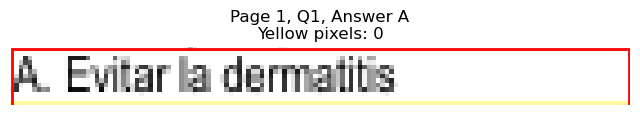

Page 1, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=148.0, y1=127.3
Page 1, Q1, B: Yellow pixels: 1381
Page 1, Q1, B: Total non-white pixels: 1988
Page 1, Q1, B: Yellow percentage: 69.5%


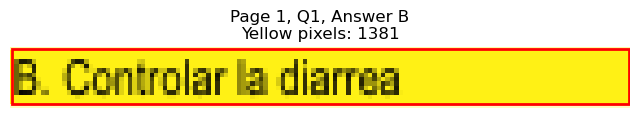

Page 1, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=447.9, y1=114.7
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 638
Page 1, Q1, C: Yellow percentage: 0.0%


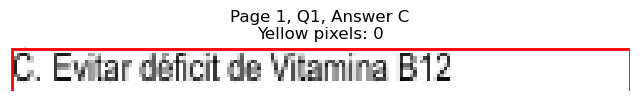

Page 1, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=440.8, y1=127.3
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 625
Page 1, Q1, D: Yellow percentage: 0.0%


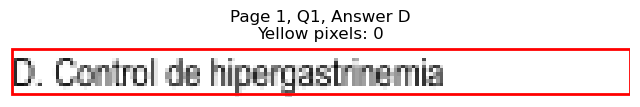


Page 1, Q1 - Selected Answer: B (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=178.1, y1=165.2
Page 1, Q2, A: Yellow pixels: 173
Page 1, Q2, A: Total non-white pixels: 756
Page 1, Q2, A: Yellow percentage: 22.9%


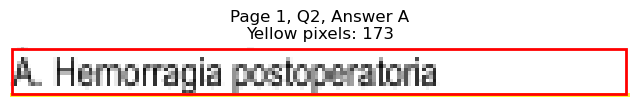

Page 1, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=144.0, y1=177.8
Page 1, Q2, B: Yellow pixels: 1485
Page 1, Q2, B: Total non-white pixels: 1807
Page 1, Q2, B: Yellow percentage: 82.2%


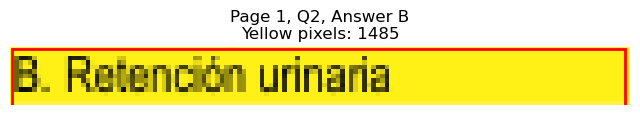

Page 1, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=388.7, y1=165.2
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 346
Page 1, Q2, C: Yellow percentage: 0.0%


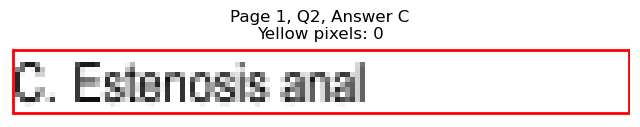

Page 1, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=404.8, y1=177.8
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 438
Page 1, Q2, D: Yellow percentage: 0.0%


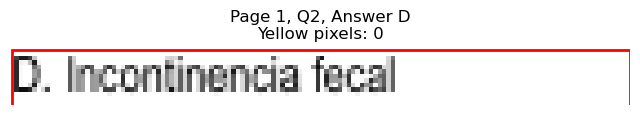


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=215.6, x1=132.5, y1=228.3
Page 1, Q3, A: Yellow pixels: 1262
Page 1, Q3, A: Total non-white pixels: 1778
Page 1, Q3, A: Yellow percentage: 71.0%


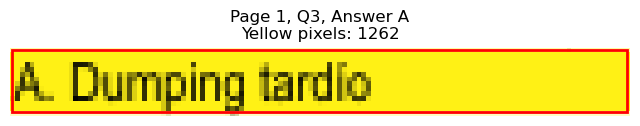

Page 1, Q3 - B: Detected box: x0=56.6, y0=228.2, x1=148.1, y1=240.9
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 565
Page 1, Q3, B: Yellow percentage: 0.0%


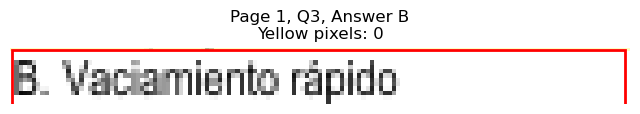

Page 1, Q3 - C: Detected box: x0=315.4, y0=215.6, x1=424.9, y1=228.3
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 524
Page 1, Q3, C: Yellow percentage: 0.0%


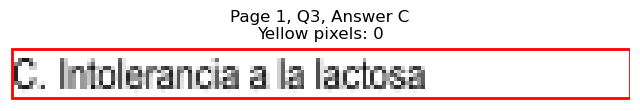

Page 1, Q3 - D: Detected box: x0=315.4, y0=228.2, x1=491.0, y1=240.9
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 891
Page 1, Q3, D: Yellow percentage: 0.0%


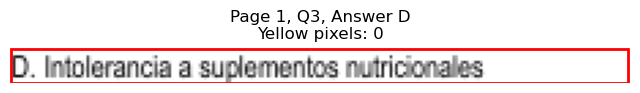


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=266.0, x1=141.0, y1=278.7
Page 1, Q4, A: Yellow pixels: 1453
Page 1, Q4, A: Total non-white pixels: 1768
Page 1, Q4, A: Yellow percentage: 82.2%


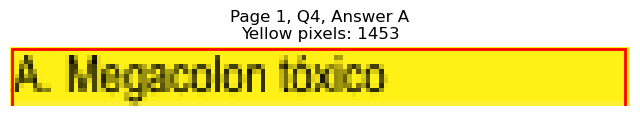

Page 1, Q4 - B: Detected box: x0=56.6, y0=278.8, x1=158.1, y1=291.4
Page 1, Q4, B: Yellow pixels: 152
Page 1, Q4, B: Total non-white pixels: 634
Page 1, Q4, B: Yellow percentage: 24.0%


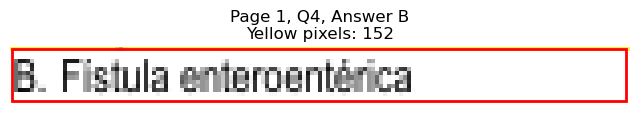

Page 1, Q4 - C: Detected box: x0=315.4, y0=266.0, x1=389.7, y1=278.7
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 364
Page 1, Q4, C: Yellow percentage: 0.0%


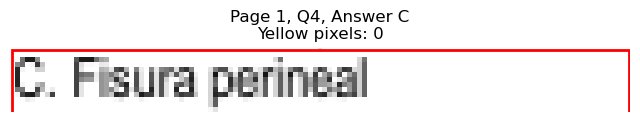

Page 1, Q4 - D: Detected box: x0=315.4, y0=278.8, x1=404.2, y1=291.4
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 464
Page 1, Q4, D: Yellow percentage: 0.0%


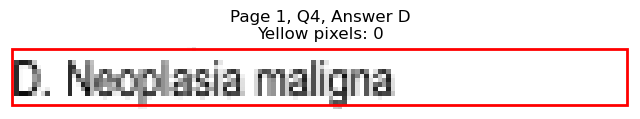


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=329.2, x1=170.7, y1=341.8
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 566
Page 1, Q5, A: Yellow percentage: 0.0%


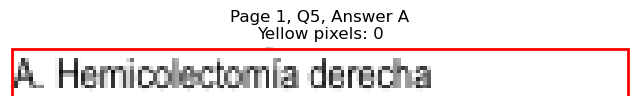

Page 1, Q5 - B: Detected box: x0=56.6, y0=341.9, x1=269.4, y1=354.6
Page 1, Q5, B: Yellow pixels: 62
Page 1, Q5, B: Total non-white pixels: 1154
Page 1, Q5, B: Yellow percentage: 5.4%


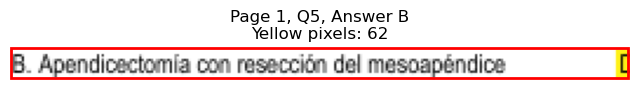

Page 1, Q5 - C: Detected box: x0=315.4, y0=329.2, x1=423.3, y1=341.8
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 532
Page 1, Q5, C: Yellow percentage: 0.0%


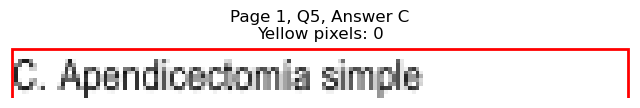

Page 1, Q5 - D: Detected box: x0=315.4, y0=341.9, x1=541.2, y1=354.6
Page 1, Q5, D: Yellow pixels: 2052
Page 1, Q5, D: Total non-white pixels: 3163
Page 1, Q5, D: Yellow percentage: 64.9%


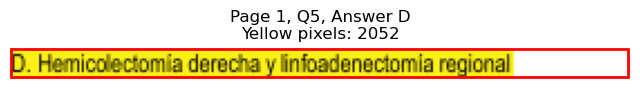


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=392.3, x1=122.0, y1=405.0
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 294
Page 1, Q6, A: Yellow percentage: 0.0%


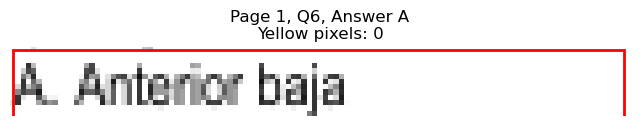

Page 1, Q6 - B: Detected box: x0=56.6, y0=404.9, x1=223.8, y1=417.6
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 801
Page 1, Q6, B: Yellow percentage: 0.0%


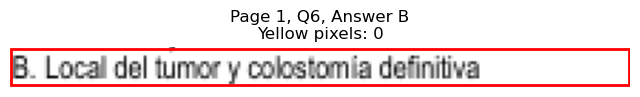

Page 1, Q6 - C: Detected box: x0=315.4, y0=392.3, x1=432.4, y1=405.0
Page 1, Q6, C: Yellow pixels: 1759
Page 1, Q6, C: Total non-white pixels: 2184
Page 1, Q6, C: Yellow percentage: 80.5%


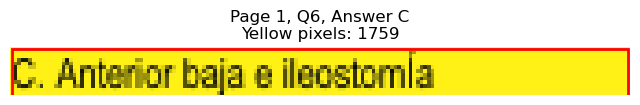

Page 1, Q6 - D: Detected box: x0=315.4, y0=404.9, x1=405.3, y1=417.6
Page 1, Q6, D: Yellow pixels: 139
Page 1, Q6, D: Total non-white pixels: 576
Page 1, Q6, D: Yellow percentage: 24.1%


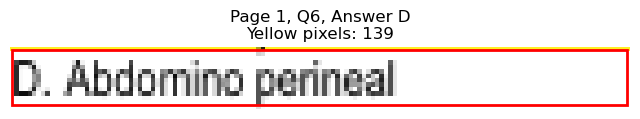


Page 1, Q6 - Selected Answer: C (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=442.8, x1=262.4, y1=455.5
Page 1, Q7, A: Yellow pixels: 2158
Page 1, Q7, A: Total non-white pixels: 3164
Page 1, Q7, A: Yellow percentage: 68.2%


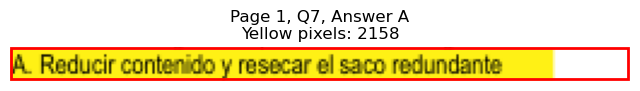

Page 1, Q7 - B: Detected box: x0=56.6, y0=455.5, x1=223.2, y1=468.1
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 778
Page 1, Q7, B: Yellow percentage: 0.0%


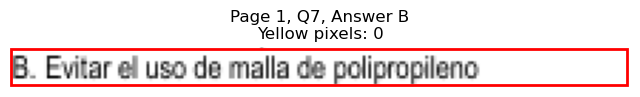

Page 1, Q7 - C: Detected box: x0=315.4, y0=442.8, x1=467.5, y1=455.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 732
Page 1, Q7, C: Yellow percentage: 0.0%


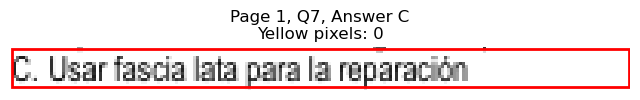

Page 1, Q7 - D: Detected box: x0=315.4, y0=455.5, x1=435.4, y1=468.1
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 602
Page 1, Q7, D: Yellow percentage: 0.0%


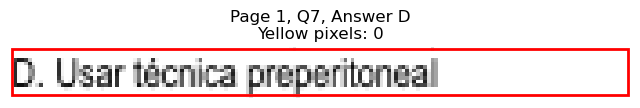


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=506.0, x1=138.1, y1=518.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 405
Page 1, Q8, A: Yellow percentage: 0.0%


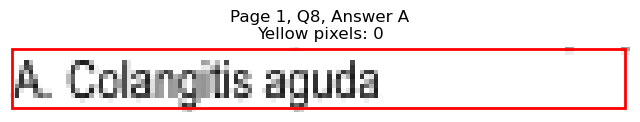

Page 1, Q8 - B: Detected box: x0=56.6, y0=518.6, x1=145.6, y1=531.2
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 468
Page 1, Q8, B: Yellow percentage: 0.0%


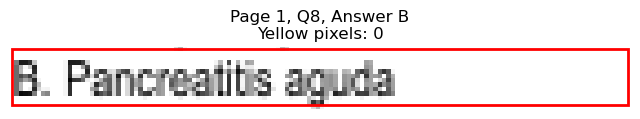

Page 1, Q8 - C: Detected box: x0=315.4, y0=506.0, x1=400.7, y1=518.6
Page 1, Q8, C: Yellow pixels: 136
Page 1, Q8, C: Total non-white pixels: 585
Page 1, Q8, C: Yellow percentage: 23.2%


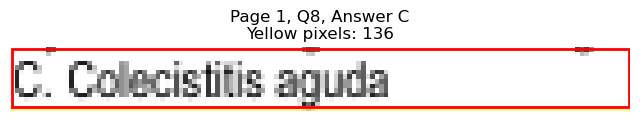

Page 1, Q8 - D: Detected box: x0=315.4, y0=518.6, x1=366.2, y1=531.2
Page 1, Q8, D: Yellow pixels: 1143
Page 1, Q8, D: Total non-white pixels: 1428
Page 1, Q8, D: Yellow percentage: 80.0%


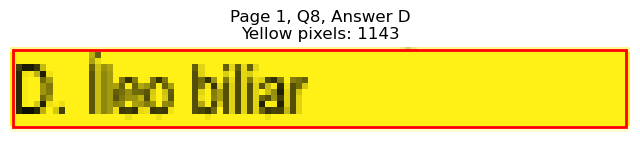


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=569.1, x1=214.4, y1=581.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 801
Page 1, Q9, A: Yellow percentage: 0.0%


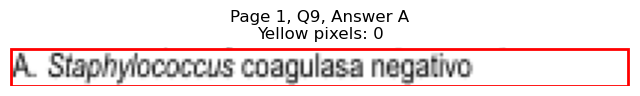

Page 1, Q9 - B: Detected box: x0=56.6, y0=581.7, x1=125.5, y1=594.3
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 325
Page 1, Q9, B: Yellow percentage: 0.0%


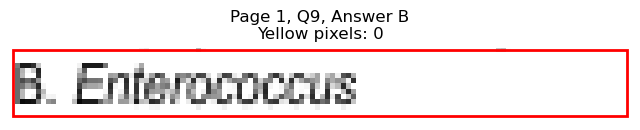

Page 1, Q9 - C: Detected box: x0=315.4, y0=569.1, x1=392.7, y1=581.7
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 501
Page 1, Q9, C: Yellow percentage: 0.0%


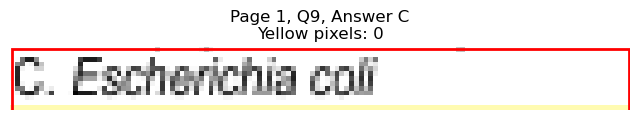

Page 1, Q9 - D: Detected box: x0=315.4, y0=581.7, x1=423.3, y1=594.3
Page 1, Q9, D: Yellow pixels: 1509
Page 1, Q9, D: Total non-white pixels: 2226
Page 1, Q9, D: Yellow percentage: 67.8%


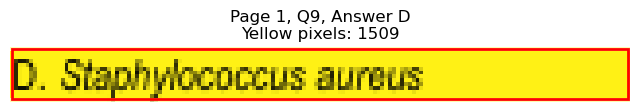


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)
Page 1, Q10 - A: Detected box: x0=56.6, y0=644.8, x1=93.9, y1=657.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 162
Page 1, Q10, A: Yellow percentage: 0.0%


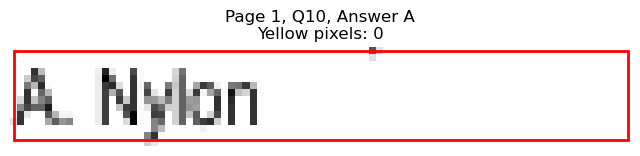

Page 1, Q10 - B: Detected box: x0=56.6, y0=657.4, x1=126.0, y1=670.1
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 322
Page 1, Q10, B: Yellow percentage: 0.0%


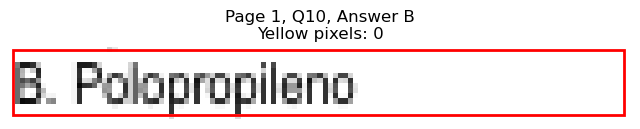

Page 1, Q10 - C: Detected box: x0=315.4, y0=644.8, x1=382.7, y1=657.5
Page 1, Q10, C: Yellow pixels: 1304
Page 1, Q10, C: Total non-white pixels: 1652
Page 1, Q10, C: Yellow percentage: 78.9%


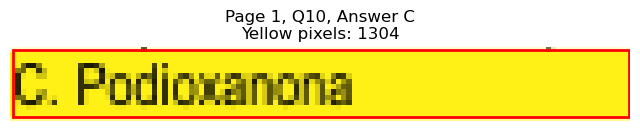

Page 1, Q10 - D: Detected box: x0=315.4, y0=657.4, x1=393.8, y1=670.1
Page 1, Q10, D: Yellow pixels: 129
Page 1, Q10, D: Total non-white pixels: 509
Page 1, Q10, D: Yellow percentage: 25.3%


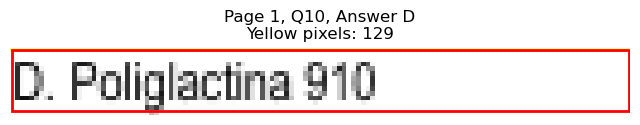


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)
Page 1, Q11 - A: Detected box: x0=56.6, y0=708.0, x1=112.0, y1=720.6
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 234
Page 1, Q11, A: Yellow percentage: 0.0%


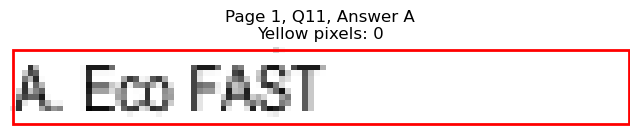

Page 1, Q11 - B: Detected box: x0=56.6, y0=720.6, x1=153.6, y1=733.2
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 487
Page 1, Q11, B: Yellow percentage: 0.0%


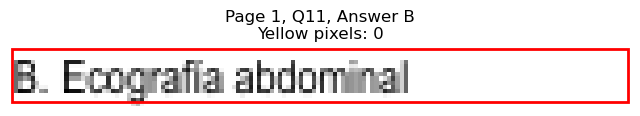

Page 1, Q11 - C: Detected box: x0=315.4, y0=708.0, x1=458.0, y1=720.6
Page 1, Q11, C: Yellow pixels: 193
Page 1, Q11, C: Total non-white pixels: 923
Page 1, Q11, C: Yellow percentage: 20.9%


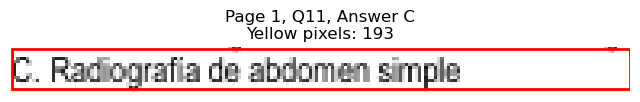

Page 1, Q11 - D: Detected box: x0=315.4, y0=720.6, x1=440.4, y1=733.2
Page 1, Q11, D: Yellow pixels: 1844
Page 1, Q11, D: Total non-white pixels: 2464
Page 1, Q11, D: Yellow percentage: 74.8%


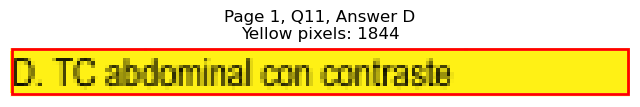


Page 1, Q11 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=374.2, y1=102.1
Page 2, Q1, A: Yellow pixels: 369
Page 2, Q1, A: Total non-white pixels: 1965
Page 2, Q1, A: Yellow percentage: 18.8%


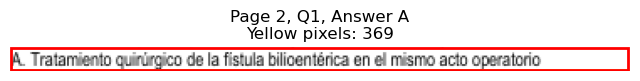

Page 2, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=225.9, y1=114.7
Page 2, Q1, B: Yellow pixels: 2229
Page 2, Q1, B: Total non-white pixels: 2860
Page 2, Q1, B: Yellow percentage: 77.9%


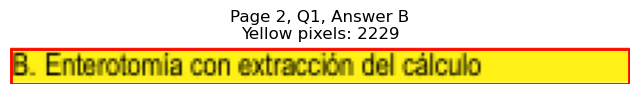

Page 2, Q1 - C: Detected box: x0=56.6, y0=114.6, x1=169.6, y1=127.3
Page 2, Q1, C: Yellow pixels: 164
Page 2, Q1, C: Total non-white pixels: 747
Page 2, Q1, C: Yellow percentage: 22.0%


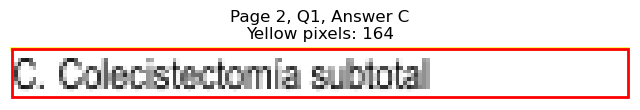

Page 2, Q1 - D: Detected box: x0=56.6, y0=127.2, x1=135.5, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 397
Page 2, Q1, D: Yellow percentage: 0.0%


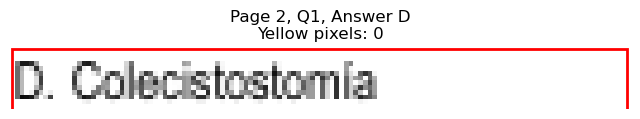


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=102.9, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 204
Page 2, Q2, A: Yellow percentage: 0.0%


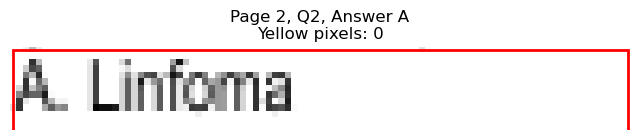

Page 2, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=135.0, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 372
Page 2, Q2, B: Yellow percentage: 0.0%


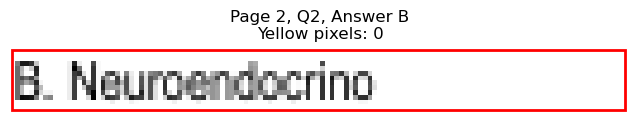

Page 2, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=397.7, y1=177.8
Page 2, Q2, C: Yellow pixels: 1449
Page 2, Q2, C: Total non-white pixels: 1729
Page 2, Q2, C: Yellow percentage: 83.8%


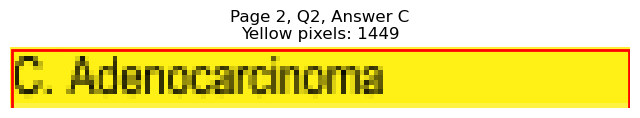

Page 2, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=396.3, y1=190.4
Page 2, Q2, D: Yellow pixels: 132
Page 2, Q2, D: Total non-white pixels: 499
Page 2, Q2, D: Yellow percentage: 26.5%


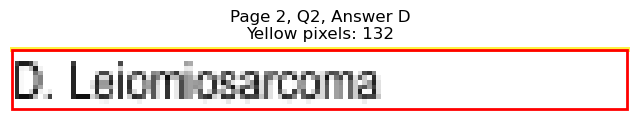


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=165.1, y1=253.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 564
Page 2, Q3, A: Yellow percentage: 0.0%


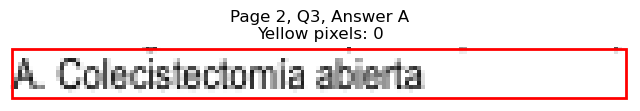

Page 2, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=257.4, y1=266.1
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 1020
Page 2, Q3, B: Yellow percentage: 0.0%


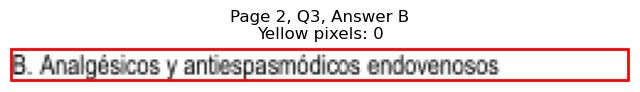

Page 2, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=452.5, y1=253.5
Page 2, Q3, C: Yellow pixels: 1903
Page 2, Q3, C: Total non-white pixels: 2632
Page 2, Q3, C: Yellow percentage: 72.3%


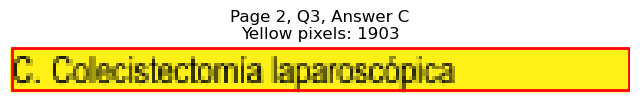

Page 2, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=455.0, y1=266.1
Page 2, Q3, D: Yellow pixels: 190
Page 2, Q3, D: Total non-white pixels: 880
Page 2, Q3, D: Yellow percentage: 21.6%


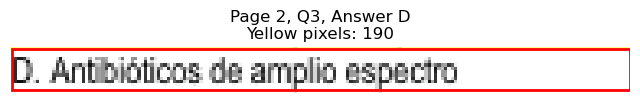


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=161.1, y1=316.6
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 502
Page 2, Q4, A: Yellow percentage: 0.0%


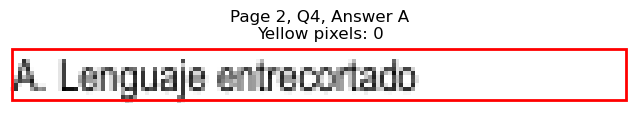

Page 2, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=130.9, y1=329.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 353
Page 2, Q4, B: Yellow percentage: 0.0%


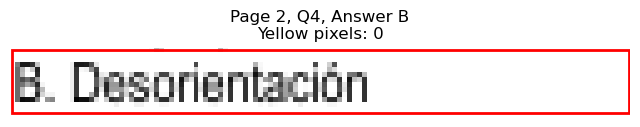

Page 2, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=374.2, y1=316.6
Page 2, Q4, C: Yellow pixels: 1220
Page 2, Q4, C: Total non-white pixels: 1430
Page 2, Q4, C: Yellow percentage: 85.3%


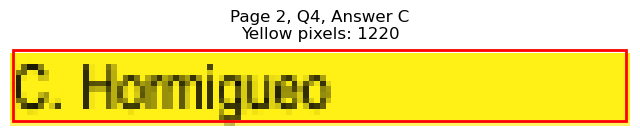

Page 2, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=374.7, y1=329.2
Page 2, Q4, D: Yellow pixels: 108
Page 2, Q4, D: Total non-white pixels: 389
Page 2, Q4, D: Yellow percentage: 27.8%


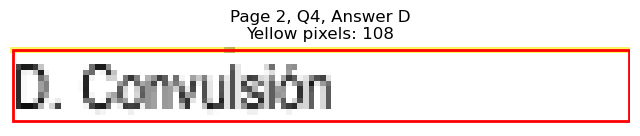


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=179.7, y1=367.2
Page 2, Q5, A: Yellow pixels: 174
Page 2, Q5, A: Total non-white pixels: 792
Page 2, Q5, A: Yellow percentage: 22.0%


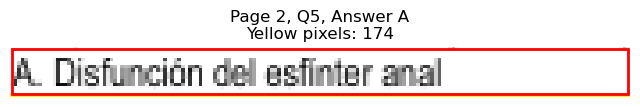

Page 2, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=140.1, y1=379.8
Page 2, Q5, B: Yellow pixels: 1434
Page 2, Q5, B: Total non-white pixels: 1755
Page 2, Q5, B: Yellow percentage: 81.7%


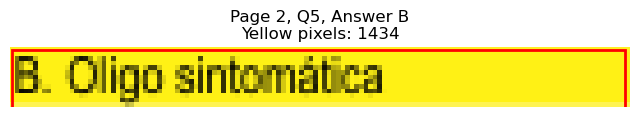

Page 2, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=366.2, y1=367.2
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 236
Page 2, Q5, C: Yellow percentage: 0.0%


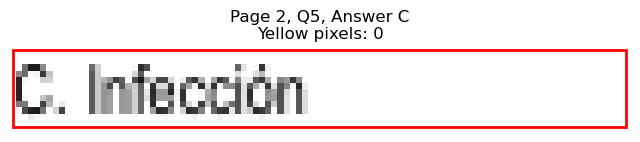

Page 2, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=398.2, y1=379.8
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 397
Page 2, Q5, D: Yellow percentage: 0.0%


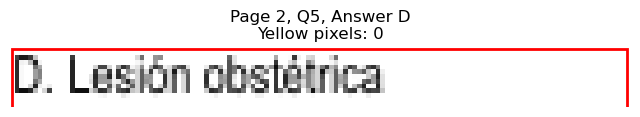


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=430.2, x1=154.6, y1=442.9
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 605
Page 2, Q6, A: Yellow percentage: 0.0%


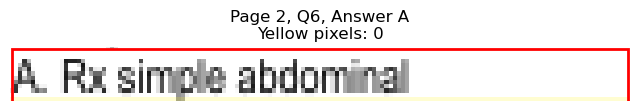

Page 2, Q6 - B: Detected box: x0=56.6, y0=442.8, x1=153.6, y1=455.5
Page 2, Q6, B: Yellow pixels: 1524
Page 2, Q6, B: Total non-white pixels: 2072
Page 2, Q6, B: Yellow percentage: 73.6%


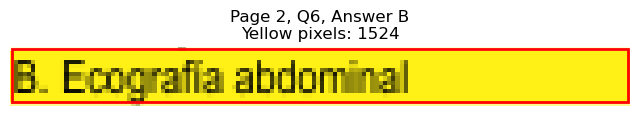

Page 2, Q6 - C: Detected box: x0=315.4, y0=430.2, x1=434.8, y1=442.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 569
Page 2, Q6, C: Yellow percentage: 0.0%


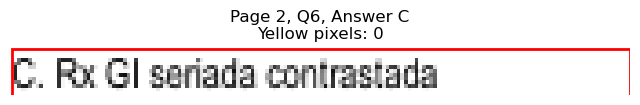

Page 2, Q6 - D: Detected box: x0=315.4, y0=442.8, x1=420.3, y1=455.5
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 516
Page 2, Q6, D: Yellow percentage: 0.0%


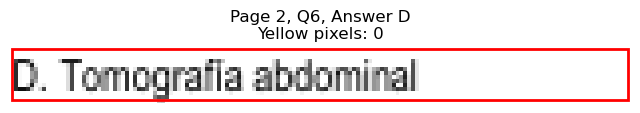


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=275.0, y1=493.4
Page 2, Q7, A: Yellow pixels: 2380
Page 2, Q7, A: Total non-white pixels: 3766
Page 2, Q7, A: Yellow percentage: 63.2%


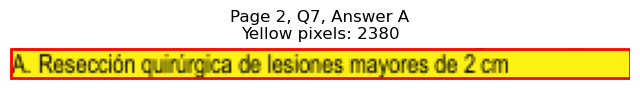

Page 2, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=296.1, y1=506.0
Page 2, Q7, B: Yellow pixels: 4
Page 2, Q7, B: Total non-white pixels: 1489
Page 2, Q7, B: Yellow percentage: 0.3%


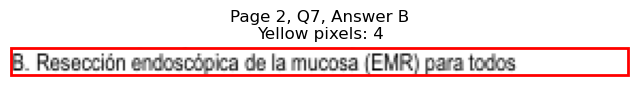

Page 2, Q7 - C: Detected box: x0=56.6, y0=506.0, x1=279.9, y1=518.6
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 1080
Page 2, Q7, C: Yellow percentage: 0.0%


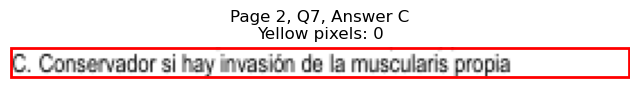

Page 2, Q7 - D: Detected box: x0=56.6, y0=518.6, x1=287.4, y1=531.2
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 1096
Page 2, Q7, D: Yellow percentage: 0.0%


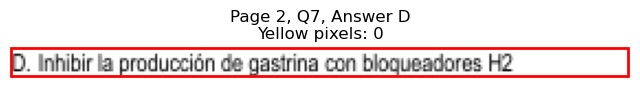


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=556.5, x1=135.0, y1=569.1
Page 2, Q8, A: Yellow pixels: 130
Page 2, Q8, A: Total non-white pixels: 541
Page 2, Q8, A: Yellow percentage: 24.0%


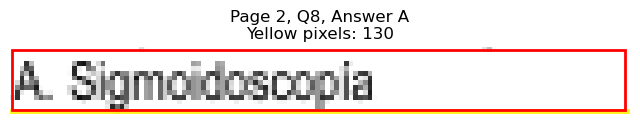

Page 2, Q8 - B: Detected box: x0=56.6, y0=569.1, x1=126.0, y1=581.7
Page 2, Q8, B: Yellow pixels: 1317
Page 2, Q8, B: Total non-white pixels: 1573
Page 2, Q8, B: Yellow percentage: 83.7%


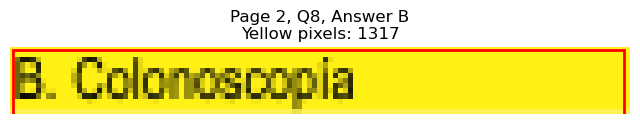

Page 2, Q8 - C: Detected box: x0=315.4, y0=556.5, x1=379.7, y1=569.1
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 321
Page 2, Q8, C: Yellow percentage: 0.0%


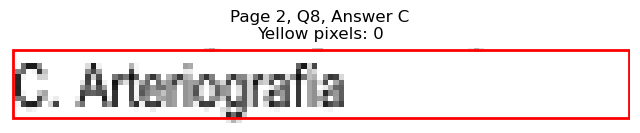

Page 2, Q8 - D: Detected box: x0=315.4, y0=569.1, x1=403.3, y1=581.7
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 434
Page 2, Q8, D: Yellow percentage: 0.0%


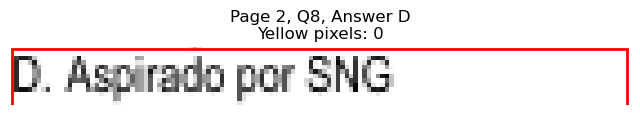


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=632.2, x1=186.1, y1=644.9
Page 2, Q9, A: Yellow pixels: 1859
Page 2, Q9, A: Total non-white pixels: 2353
Page 2, Q9, A: Yellow percentage: 79.0%


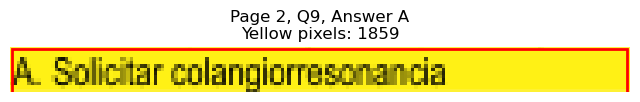

Page 2, Q9 - B: Detected box: x0=56.6, y0=644.8, x1=198.3, y1=657.5
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 686
Page 2, Q9, B: Yellow percentage: 0.0%


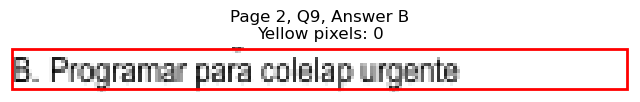

Page 2, Q9 - C: Detected box: x0=315.4, y0=632.2, x1=419.3, y1=644.9
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 512
Page 2, Q9, C: Yellow percentage: 0.0%


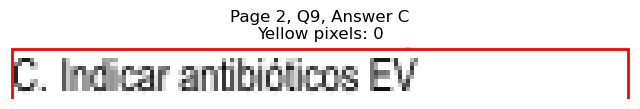

Page 2, Q9 - D: Detected box: x0=315.4, y0=644.8, x1=466.5, y1=657.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 758
Page 2, Q9, D: Yellow percentage: 0.0%


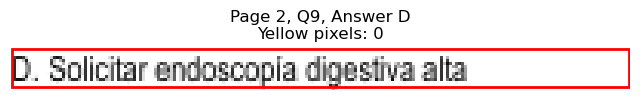


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)
Page 2, Q10 - A: Detected box: x0=56.6, y0=682.8, x1=113.9, y1=695.4
Page 2, Q10, A: Yellow pixels: 108
Page 2, Q10, A: Total non-white pixels: 393
Page 2, Q10, A: Yellow percentage: 27.5%


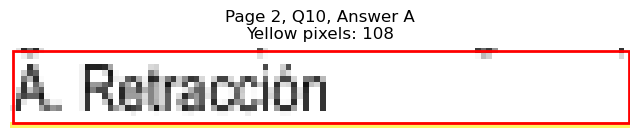

Page 2, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=105.9, y1=708.0
Page 2, Q10, B: Yellow pixels: 1122
Page 2, Q10, B: Total non-white pixels: 1300
Page 2, Q10, B: Yellow percentage: 86.3%


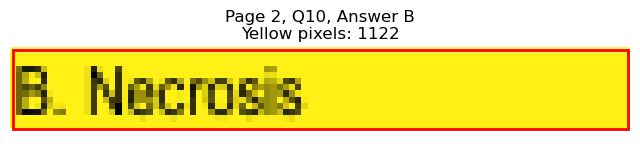

Page 2, Q10 - C: Detected box: x0=315.4, y0=682.8, x1=365.7, y1=695.4
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 219
Page 2, Q10, C: Yellow percentage: 0.0%


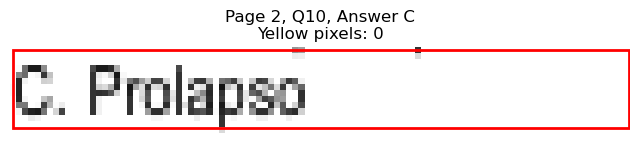

Page 2, Q10 - D: Detected box: x0=315.4, y0=695.4, x1=408.8, y1=708.0
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 454
Page 2, Q10, D: Yellow percentage: 0.0%


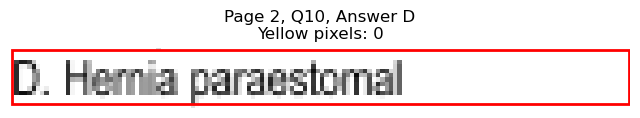


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)

Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=153.6, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 480
Page 3, Q1, A: Yellow percentage: 0.0%


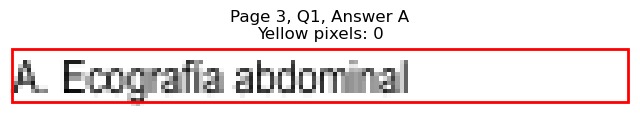

Page 3, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=163.1, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 489
Page 3, Q1, B: Yellow percentage: 0.0%


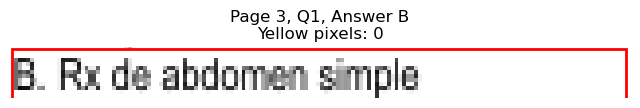

Page 3, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=439.9, y1=127.3
Page 3, Q1, C: Yellow pixels: 175
Page 3, Q1, C: Total non-white pixels: 780
Page 3, Q1, C: Yellow percentage: 22.4%


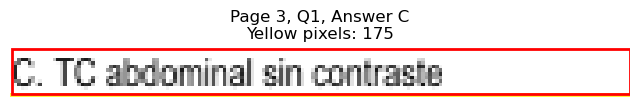

Page 3, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=422.3, y1=139.9
Page 3, Q1, D: Yellow pixels: 1640
Page 3, Q1, D: Total non-white pixels: 2054
Page 3, Q1, D: Yellow percentage: 79.8%


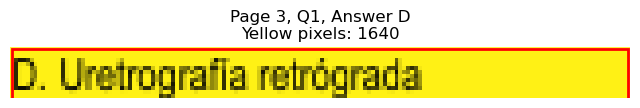


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=124.5, y1=177.8
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 335
Page 3, Q2, A: Yellow percentage: 0.0%


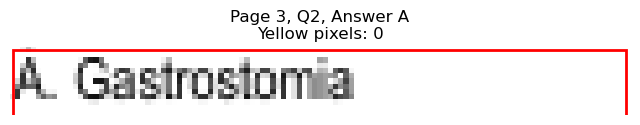

Page 3, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=159.1, y1=190.4
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 509
Page 3, Q2, B: Yellow percentage: 0.0%


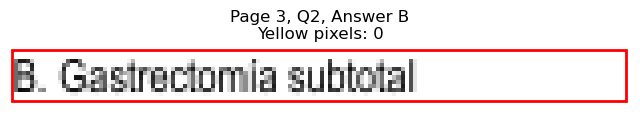

Page 3, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=432.8, y1=177.8
Page 3, Q2, C: Yellow pixels: 1743
Page 3, Q2, C: Total non-white pixels: 2184
Page 3, Q2, C: Yellow percentage: 79.8%


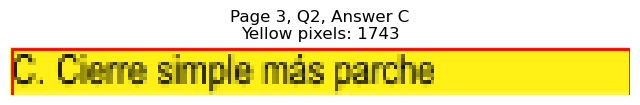

Page 3, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=406.7, y1=190.4
Page 3, Q2, D: Yellow pixels: 142
Page 3, Q2, D: Total non-white pixels: 594
Page 3, Q2, D: Yellow percentage: 23.9%


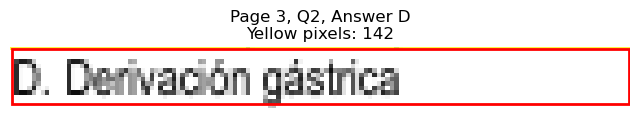


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=313.6, y1=253.5
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 1271
Page 3, Q3, A: Yellow percentage: 0.0%


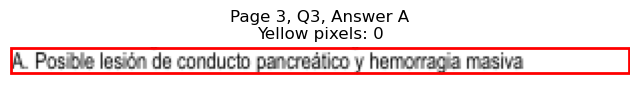

Page 3, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=251.8, y1=266.1
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 957
Page 3, Q3, B: Yellow percentage: 0.0%


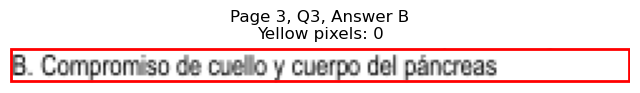

Page 3, Q3 - C: Detected box: x0=56.6, y0=266.0, x1=316.1, y1=278.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 1240
Page 3, Q3, C: Yellow percentage: 0.0%


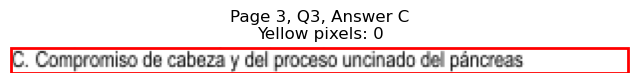

Page 3, Q3 - D: Detected box: x0=56.6, y0=278.8, x1=267.5, y1=291.4
Page 3, Q3, D: Yellow pixels: 2598
Page 3, Q3, D: Total non-white pixels: 3668
Page 3, Q3, D: Yellow percentage: 70.8%


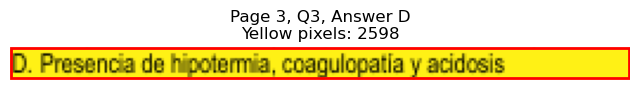


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=286.5, y1=354.6
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 1103
Page 3, Q4, A: Yellow percentage: 0.0%


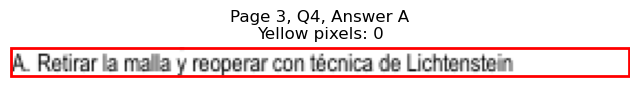

Page 3, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=205.2, y1=367.2
Page 3, Q4, B: Yellow pixels: 200
Page 3, Q4, B: Total non-white pixels: 902
Page 3, Q4, B: Yellow percentage: 22.2%


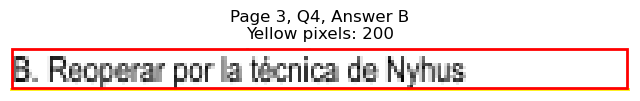

Page 3, Q4 - C: Detected box: x0=56.6, y0=367.1, x1=291.4, y1=379.8
Page 3, Q4, C: Yellow pixels: 2838
Page 3, Q4, C: Total non-white pixels: 3718
Page 3, Q4, C: Yellow percentage: 76.3%


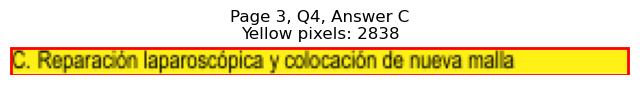

Page 3, Q4 - D: Detected box: x0=56.6, y0=379.7, x1=232.7, y1=392.4
Page 3, Q4, D: Yellow pixels: 226
Page 3, Q4, D: Total non-white pixels: 1061
Page 3, Q4, D: Yellow percentage: 21.3%


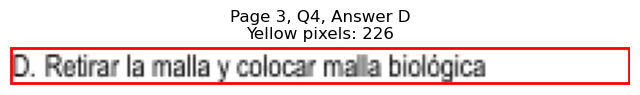


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=128.5, y1=430.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 359
Page 3, Q5, A: Yellow percentage: 0.0%


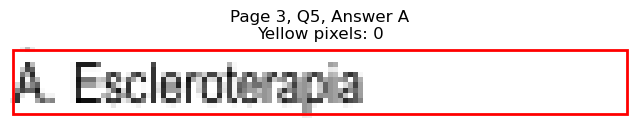

Page 3, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=159.0, y1=442.9
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 495
Page 3, Q5, B: Yellow percentage: 0.0%


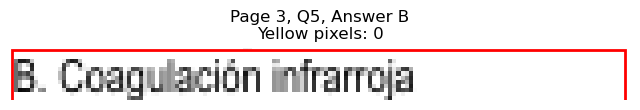

Page 3, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=373.6, y1=430.3
Page 3, Q5, C: Yellow pixels: 109
Page 3, Q5, C: Total non-white pixels: 389
Page 3, Q5, C: Yellow percentage: 28.0%


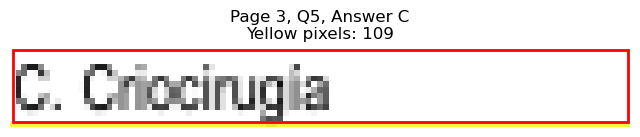

Page 3, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=440.3, y1=442.9
Page 3, Q5, D: Yellow pixels: 1833
Page 3, Q5, D: Total non-white pixels: 2288
Page 3, Q5, D: Yellow percentage: 80.1%


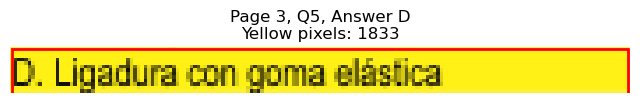


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=114.6, x1=153.6, y1=127.3
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 480
Page 3, Q6, A: Yellow percentage: 0.0%


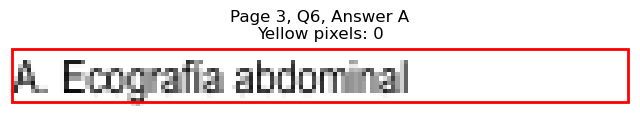

Page 3, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=170.1, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 554
Page 3, Q6, B: Yellow percentage: 0.0%


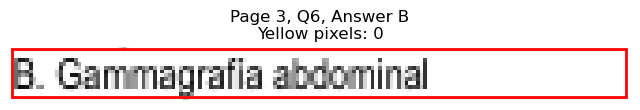

Page 3, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=388.3, y1=493.4
Page 3, Q6, C: Yellow pixels: 124
Page 3, Q6, C: Total non-white pixels: 485
Page 3, Q6, C: Yellow percentage: 25.6%


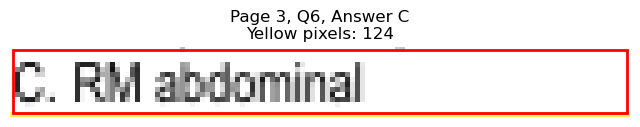

Page 3, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=382.3, y1=506.0
Page 3, Q6, D: Yellow pixels: 1297
Page 3, Q6, D: Total non-white pixels: 1534
Page 3, Q6, D: Yellow percentage: 84.6%


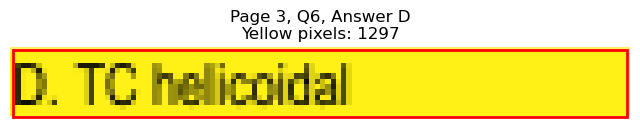


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=178.6, y1=543.8
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 572
Page 3, Q7, A: Yellow percentage: 0.0%


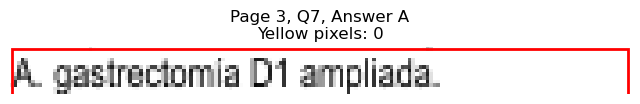

Page 3, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=197.3, y1=556.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 679
Page 3, Q7, B: Yellow percentage: 0.0%


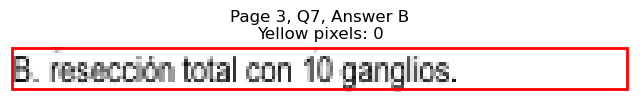

Page 3, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=398.7, y1=543.8
Page 3, Q7, C: Yellow pixels: 1461
Page 3, Q7, C: Total non-white pixels: 1742
Page 3, Q7, C: Yellow percentage: 83.9%


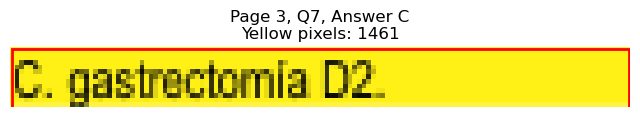

Page 3, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=496.2, y1=556.4
Page 3, Q7, D: Yellow pixels: 221
Page 3, Q7, D: Total non-white pixels: 1052
Page 3, Q7, D: Yellow percentage: 21.0%


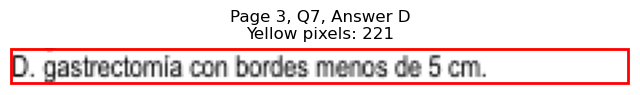


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=151.1, y1=619.5
Page 3, Q8, A: Yellow pixels: 1531
Page 3, Q8, A: Total non-white pixels: 2044
Page 3, Q8, A: Yellow percentage: 74.9%


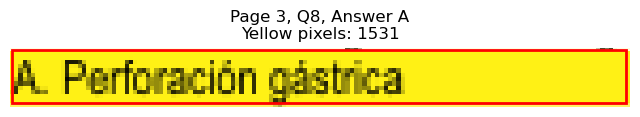

Page 3, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=190.2, y1=632.3
Page 3, Q8, B: Yellow pixels: 184
Page 3, Q8, B: Total non-white pixels: 852
Page 3, Q8, B: Yellow percentage: 21.6%


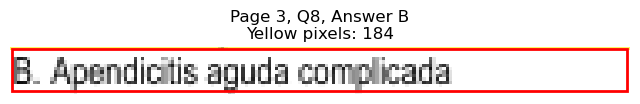

Page 3, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=410.3, y1=619.5
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 468
Page 3, Q8, C: Yellow percentage: 0.0%


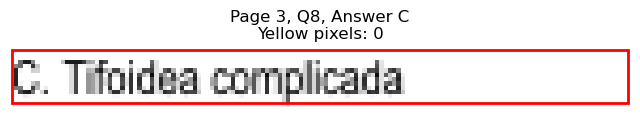

Page 3, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=406.7, y1=632.3
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 453
Page 3, Q8, D: Yellow percentage: 0.0%


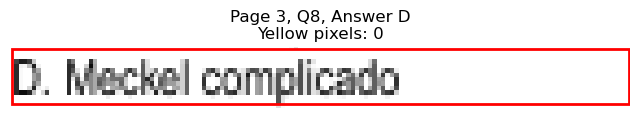


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=166.6, y1=670.1
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 498
Page 3, Q9, A: Yellow percentage: 0.0%


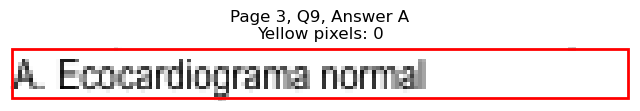

Page 3, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=213.3, y1=682.7
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 743
Page 3, Q9, B: Yellow percentage: 0.0%


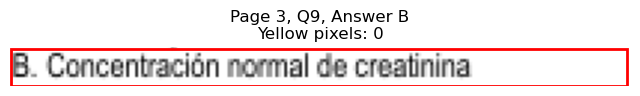

Page 3, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=452.9, y1=670.1
Page 3, Q9, C: Yellow pixels: 188
Page 3, Q9, C: Total non-white pixels: 843
Page 3, Q9, C: Yellow percentage: 22.3%


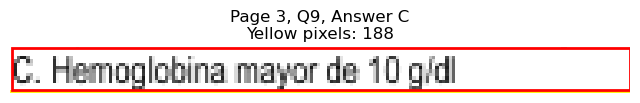

Page 3, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=462.4, y1=682.7
Page 3, Q9, D: Yellow pixels: 2022
Page 3, Q9, D: Total non-white pixels: 2574
Page 3, Q9, D: Yellow percentage: 78.6%


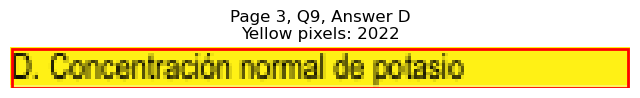


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)
Page 3, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=118.1, y1=720.6
Page 3, Q10, A: Yellow pixels: 1259
Page 3, Q10, A: Total non-white pixels: 1582
Page 3, Q10, A: Yellow percentage: 79.6%


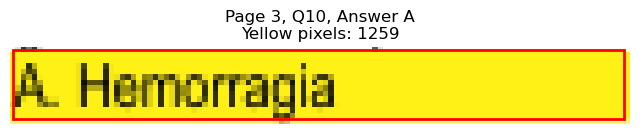

Page 3, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=160.7, y1=733.2
Page 3, Q10, B: Yellow pixels: 153
Page 3, Q10, B: Total non-white pixels: 636
Page 3, Q10, B: Yellow percentage: 24.1%


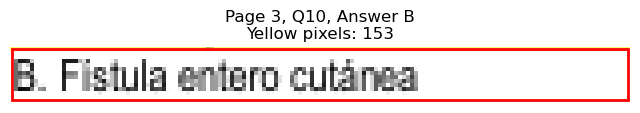

Page 3, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=442.9, y1=720.6
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 668
Page 3, Q10, C: Yellow percentage: 0.0%


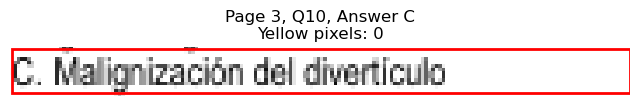

Page 3, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=473.5, y1=733.2
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 779
Page 3, Q10, D: Yellow percentage: 0.0%


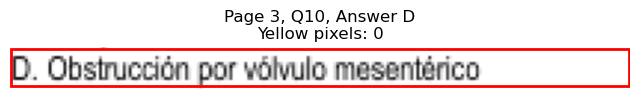


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=178.7, y1=102.1
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 603
Page 4, Q1, A: Yellow percentage: 0.0%


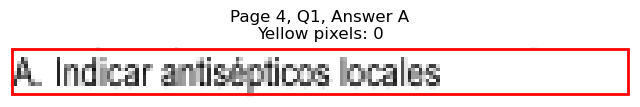

Page 4, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=179.2, y1=114.7
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 593
Page 4, Q1, B: Yellow percentage: 0.0%


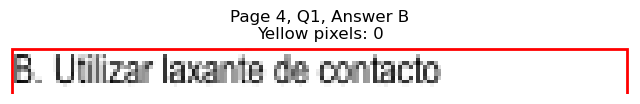

Page 4, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=424.9, y1=102.1
Page 4, Q1, C: Yellow pixels: 160
Page 4, Q1, C: Total non-white pixels: 691
Page 4, Q1, C: Yellow percentage: 23.2%


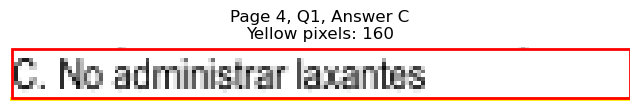

Page 4, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=418.3, y1=114.7
Page 4, Q1, D: Yellow pixels: 1624
Page 4, Q1, D: Total non-white pixels: 2002
Page 4, Q1, D: Yellow percentage: 81.1%


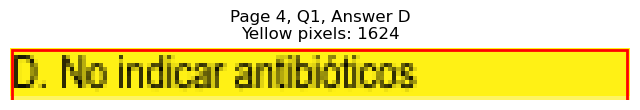


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=139.9, x1=111.4, y1=152.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 278
Page 4, Q2, A: Yellow percentage: 0.0%


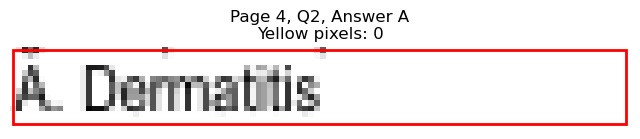

Page 4, Q2 - B: Detected box: x0=56.6, y0=152.5, x1=148.6, y1=165.2
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 452
Page 4, Q2, B: Yellow percentage: 0.0%


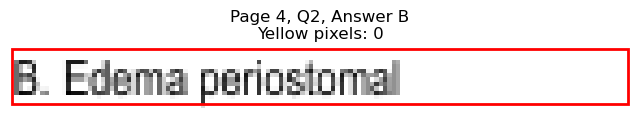

Page 4, Q2 - C: Detected box: x0=315.4, y0=139.9, x1=455.5, y1=152.6
Page 4, Q2, C: Yellow pixels: 1975
Page 4, Q2, C: Total non-white pixels: 2674
Page 4, Q2, C: Yellow percentage: 73.9%


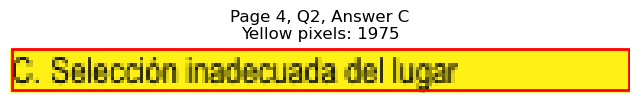

Page 4, Q2 - D: Detected box: x0=315.4, y0=152.5, x1=461.5, y1=165.2
Page 4, Q2, D: Yellow pixels: 196
Page 4, Q2, D: Total non-white pixels: 913
Page 4, Q2, D: Yellow percentage: 21.5%


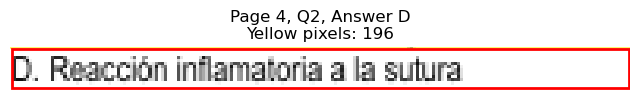


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=204.6, y1=253.5
Page 4, Q3, A: Yellow pixels: 199
Page 4, Q3, A: Total non-white pixels: 917
Page 4, Q3, A: Yellow percentage: 21.7%


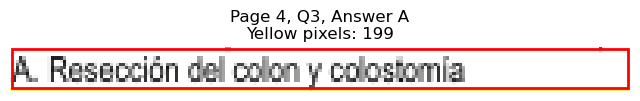

Page 4, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=202.7, y1=266.1
Page 4, Q3, B: Yellow pixels: 1985
Page 4, Q3, B: Total non-white pixels: 2758
Page 4, Q3, B: Yellow percentage: 72.0%


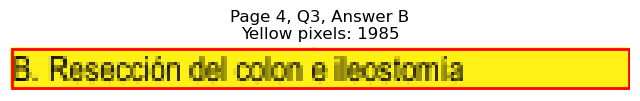

Page 4, Q3 - C: Detected box: x0=56.6, y0=266.0, x1=201.2, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 907
Page 4, Q3, C: Yellow percentage: 0.0%


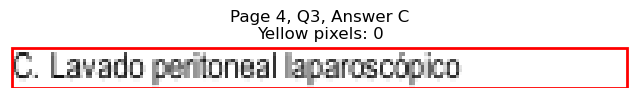

Page 4, Q3 - D: Detected box: x0=56.6, y0=278.8, x1=152.5, y1=291.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 483
Page 4, Q3, D: Yellow percentage: 0.0%


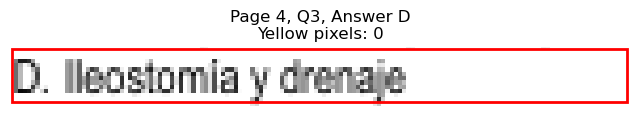


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=117.5, y1=354.6
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 285
Page 4, Q4, A: Yellow percentage: 0.0%


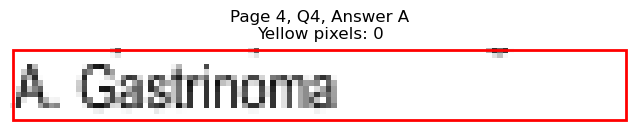

Page 4, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=127.0, y1=367.2
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 341
Page 4, Q4, B: Yellow percentage: 0.0%


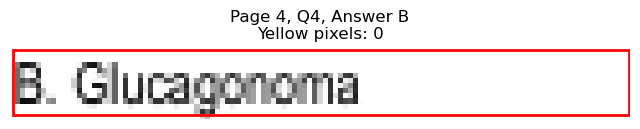

Page 4, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=373.7, y1=354.6
Page 4, Q4, C: Yellow pixels: 1221
Page 4, Q4, C: Total non-white pixels: 1526
Page 4, Q4, C: Yellow percentage: 80.0%


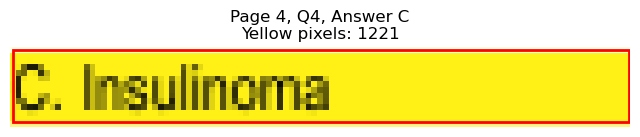

Page 4, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=400.3, y1=367.2
Page 4, Q4, D: Yellow pixels: 136
Page 4, Q4, D: Total non-white pixels: 551
Page 4, Q4, D: Yellow percentage: 24.7%


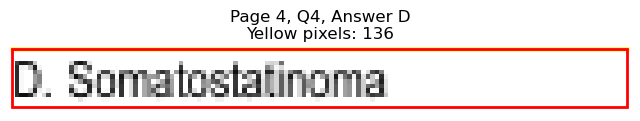


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=158.5, y1=430.3
Page 4, Q5, A: Yellow pixels: 153
Page 4, Q5, A: Total non-white pixels: 672
Page 4, Q5, A: Yellow percentage: 22.8%


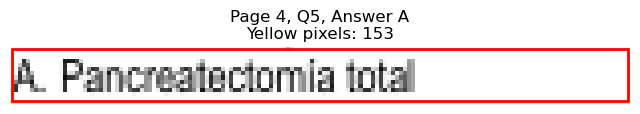

Page 4, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=131.5, y1=442.9
Page 4, Q5, B: Yellow pixels: 1351
Page 4, Q5, B: Total non-white pixels: 1638
Page 4, Q5, B: Yellow percentage: 82.5%


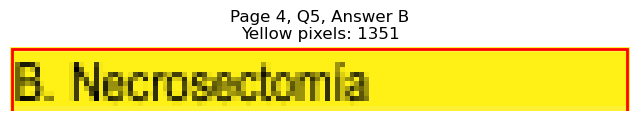

Page 4, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=391.7, y1=430.3
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 379
Page 4, Q5, C: Yellow percentage: 0.0%


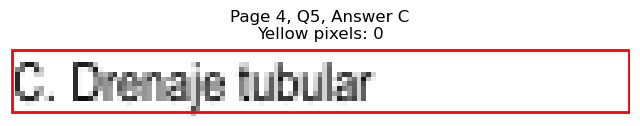

Page 4, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=457.5, y1=442.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 706
Page 4, Q5, D: Yellow percentage: 0.0%


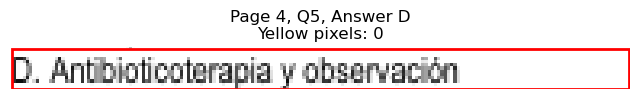


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=194.2, y1=518.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 683
Page 4, Q6, A: Yellow percentage: 0.0%


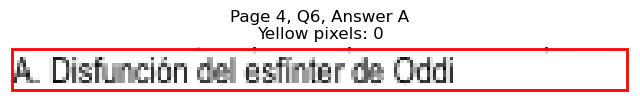

Page 4, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=148.0, y1=531.2
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 458
Page 4, Q6, B: Yellow percentage: 0.0%


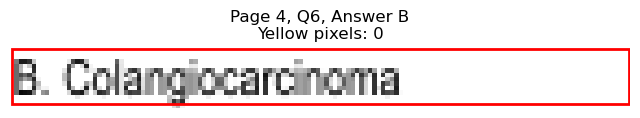

Page 4, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=458.5, y1=518.6
Page 4, Q6, C: Yellow pixels: 1960
Page 4, Q6, C: Total non-white pixels: 2716
Page 4, Q6, C: Yellow percentage: 72.2%


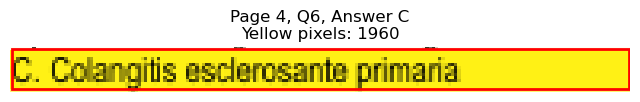

Page 4, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=415.3, y1=531.2
Page 4, Q6, D: Yellow pixels: 150
Page 4, Q6, D: Total non-white pixels: 634
Page 4, Q6, D: Yellow percentage: 23.7%


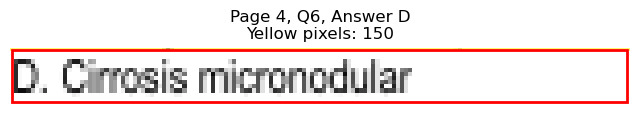


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=137.1, y1=581.7
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 387
Page 4, Q7, A: Yellow percentage: 0.0%


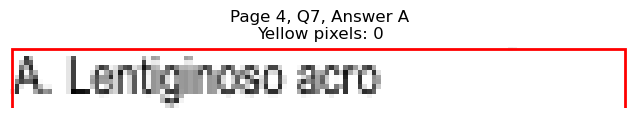

Page 4, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=134.5, y1=594.3
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 395
Page 4, Q7, B: Yellow percentage: 0.0%


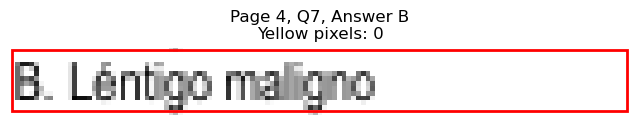

Page 4, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=361.6, y1=581.7
Page 4, Q7, C: Yellow pixels: 1081
Page 4, Q7, C: Total non-white pixels: 1261
Page 4, Q7, C: Yellow percentage: 85.7%


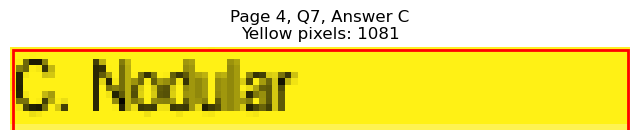

Page 4, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=412.9, y1=594.3
Page 4, Q7, D: Yellow pixels: 148
Page 4, Q7, D: Total non-white pixels: 632
Page 4, Q7, D: Yellow percentage: 23.4%


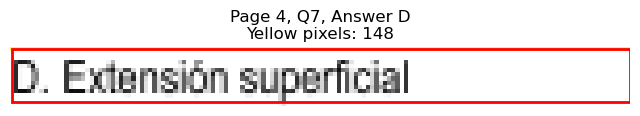


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=644.8, x1=124.5, y1=657.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 328
Page 4, Q8, A: Yellow percentage: 0.0%


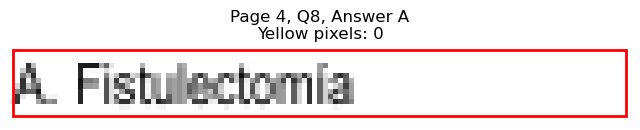

Page 4, Q8 - B: Detected box: x0=56.6, y0=657.4, x1=215.8, y1=670.1
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 769
Page 4, Q8, B: Yellow percentage: 0.0%


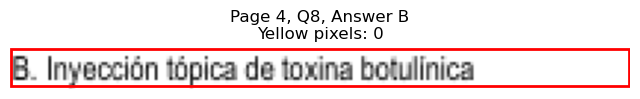

Page 4, Q8 - C: Detected box: x0=315.4, y0=644.8, x1=541.2, y1=657.5
Page 4, Q8, C: Yellow pixels: 225
Page 4, Q8, C: Total non-white pixels: 1338
Page 4, Q8, C: Yellow percentage: 16.8%


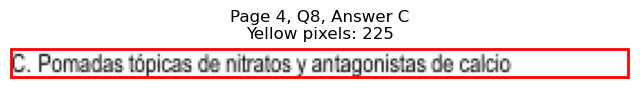

Page 4, Q8 - D: Detected box: x0=315.4, y0=657.4, x1=445.4, y1=670.1
Page 4, Q8, D: Yellow pixels: 1857
Page 4, Q8, D: Total non-white pixels: 2534
Page 4, Q8, D: Yellow percentage: 73.3%


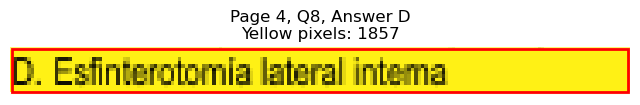


Page 4, Q8 - Selected Answer: D (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=169.1, y1=708.0
Page 4, Q9, A: Yellow pixels: 164
Page 4, Q9, A: Total non-white pixels: 882
Page 4, Q9, A: Yellow percentage: 18.6%


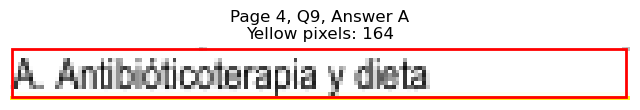

Page 4, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=227.3, y1=720.6
Page 4, Q9, B: Yellow pixels: 2249
Page 4, Q9, B: Total non-white pixels: 3108
Page 4, Q9, B: Yellow percentage: 72.4%


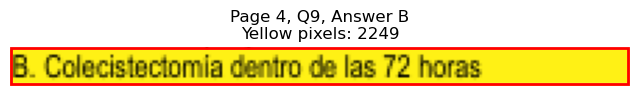

Page 4, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=464.9, y1=708.0
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 740
Page 4, Q9, C: Yellow percentage: 0.0%


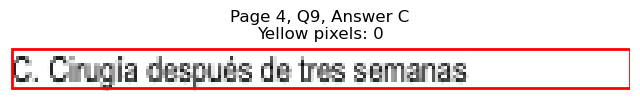

Page 4, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=476.6, y1=720.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 827
Page 4, Q9, D: Yellow percentage: 0.0%


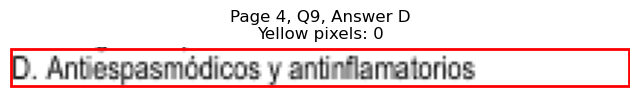


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=146.1, y1=758.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 436
Page 4, Q10, A: Yellow percentage: 0.0%


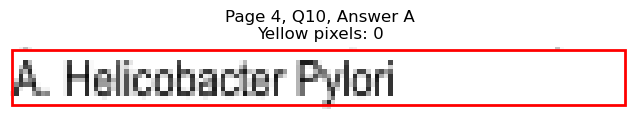

Page 4, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=89.4, y1=771.1
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 143
Page 4, Q10, B: Yellow percentage: 0.0%


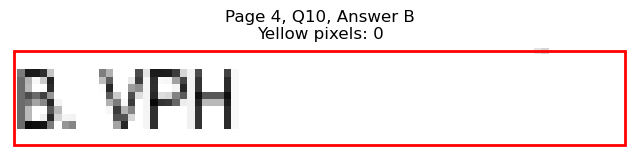

Page 4, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=450.4, y1=758.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 630
Page 4, Q10, C: Yellow percentage: 0.0%


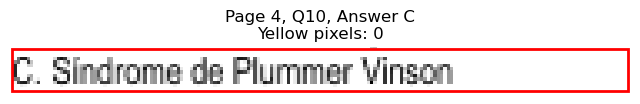

Page 4, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=368.7, y1=771.1
Page 4, Q10, D: Yellow pixels: 1152
Page 4, Q10, D: Total non-white pixels: 1456
Page 4, Q10, D: Yellow percentage: 79.1%


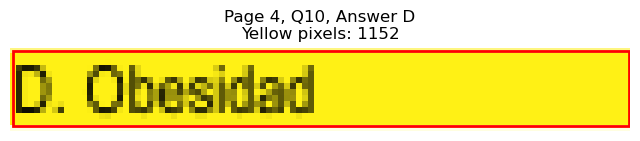


Page 4, Q10 - Selected Answer: D (based on yellow pixel count)

Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=224.2, y1=102.1
Page 5, Q1, A: Yellow pixels: 2204
Page 5, Q1, A: Total non-white pixels: 3066
Page 5, Q1, A: Yellow percentage: 71.9%


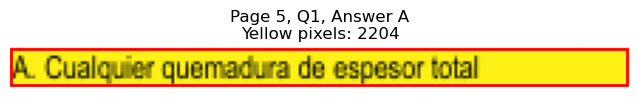

Page 5, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=312.5, y1=114.7
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 1548
Page 5, Q1, B: Yellow percentage: 0.0%


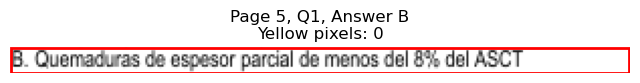

Page 5, Q1 - C: Detected box: x0=56.6, y0=114.6, x1=241.2, y1=127.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 836
Page 5, Q1, C: Yellow percentage: 0.0%


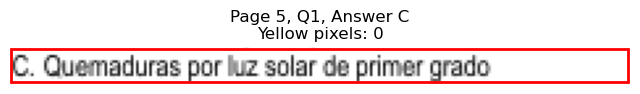

Page 5, Q1 - D: Detected box: x0=56.6, y0=127.2, x1=289.0, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1151
Page 5, Q1, D: Yellow percentage: 0.0%


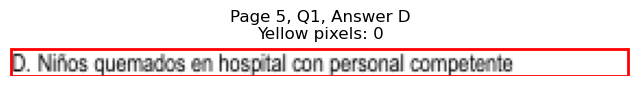


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=150.0, y1=203.0
Page 5, Q2, A: Yellow pixels: 1557
Page 5, Q2, A: Total non-white pixels: 1885
Page 5, Q2, A: Yellow percentage: 82.6%


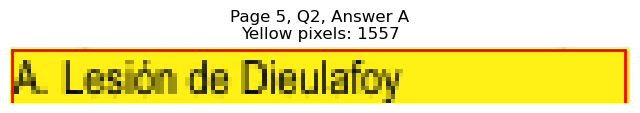

Page 5, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=162.6, y1=215.6
Page 5, Q2, B: Yellow pixels: 155
Page 5, Q2, B: Total non-white pixels: 686
Page 5, Q2, B: Yellow percentage: 22.6%


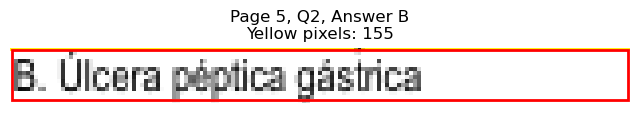

Page 5, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=423.3, y1=203.0
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 519
Page 5, Q2, C: Yellow percentage: 0.0%


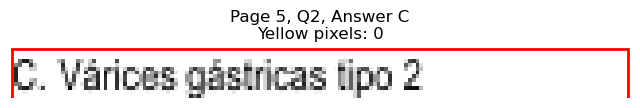

Page 5, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=432.3, y1=215.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 590
Page 5, Q2, D: Yellow percentage: 0.0%


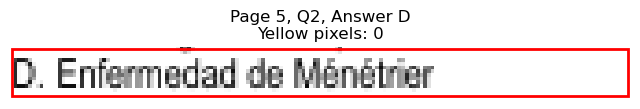


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=142.6, y1=253.5
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 434
Page 5, Q3, A: Yellow percentage: 0.0%


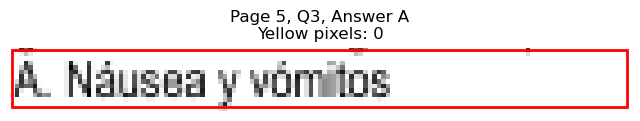

Page 5, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=150.0, y1=266.1
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 446
Page 5, Q3, B: Yellow percentage: 0.0%


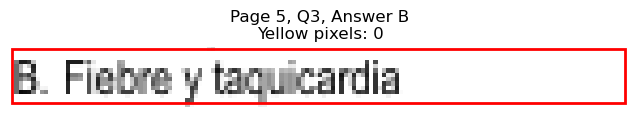

Page 5, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=464.0, y1=253.5
Page 5, Q3, C: Yellow pixels: 2051
Page 5, Q3, C: Total non-white pixels: 2786
Page 5, Q3, C: Yellow percentage: 73.6%


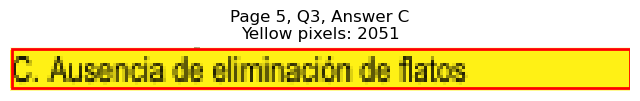

Page 5, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=441.4, y1=266.1
Page 5, Q3, D: Yellow pixels: 177
Page 5, Q3, D: Total non-white pixels: 813
Page 5, Q3, D: Yellow percentage: 21.8%


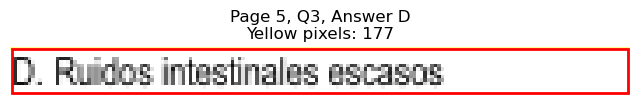


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=159.6, y1=329.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 485
Page 5, Q4, A: Yellow percentage: 0.0%


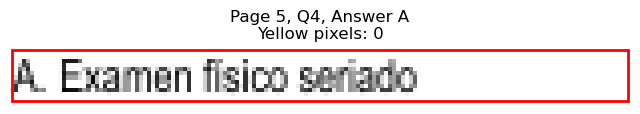

Page 5, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=93.9, y1=341.8
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 149
Page 5, Q4, B: Yellow percentage: 0.0%


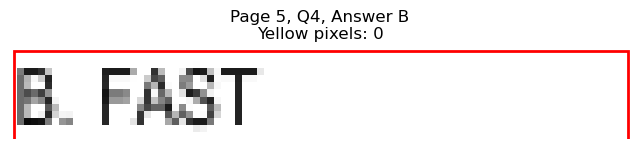

Page 5, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=432.9, y1=329.2
Page 5, Q4, C: Yellow pixels: 168
Page 5, Q4, C: Total non-white pixels: 741
Page 5, Q4, C: Yellow percentage: 22.7%


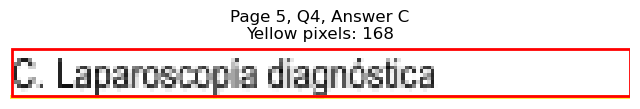

Page 5, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=447.9, y1=341.8
Page 5, Q4, D: Yellow pixels: 1873
Page 5, Q4, D: Total non-white pixels: 2379
Page 5, Q4, D: Yellow percentage: 78.7%


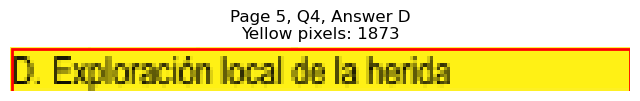


Page 5, Q4 - Selected Answer: D (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=160.1, y1=379.8
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 472
Page 5, Q5, A: Yellow percentage: 0.0%


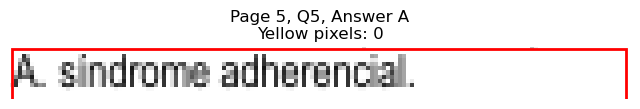

Page 5, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=195.3, y1=392.4
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 645
Page 5, Q5, B: Yellow percentage: 0.0%


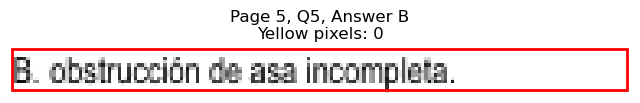

Page 5, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=419.8, y1=379.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 619
Page 5, Q5, C: Yellow percentage: 0.0%


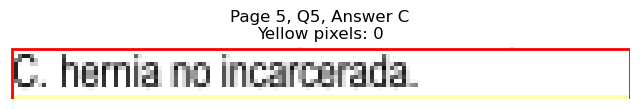

Page 5, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=500.1, y1=392.4
Page 5, Q5, D: Yellow pixels: 1981
Page 5, Q5, D: Total non-white pixels: 3164
Page 5, Q5, D: Yellow percentage: 62.6%


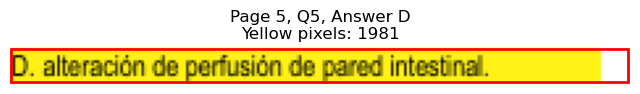


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=118.0, y1=430.3
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 299
Page 5, Q6, A: Yellow percentage: 0.0%


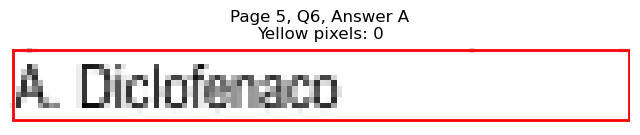

Page 5, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=121.5, y1=442.9
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 318
Page 5, Q6, B: Yellow percentage: 0.0%


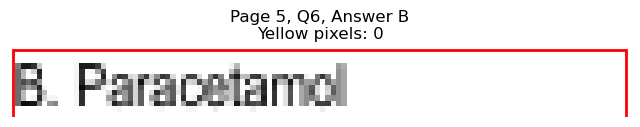

Page 5, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=377.7, y1=430.3
Page 5, Q6, C: Yellow pixels: 1129
Page 5, Q6, C: Total non-white pixels: 1582
Page 5, Q6, C: Yellow percentage: 71.4%


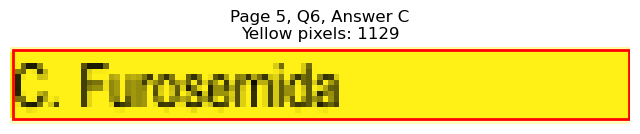

Page 5, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=387.2, y1=442.9
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 477
Page 5, Q6, D: Yellow percentage: 0.0%


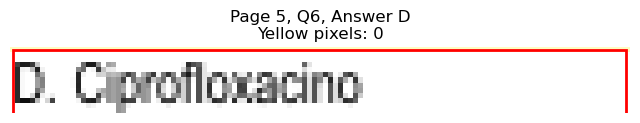


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=480.8, x1=193.2, y1=493.4
Page 5, Q7, A: Yellow pixels: 1740
Page 5, Q7, A: Total non-white pixels: 2632
Page 5, Q7, A: Yellow percentage: 66.1%


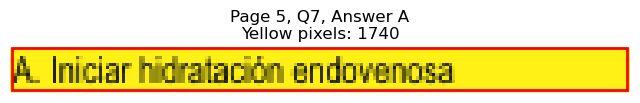

Page 5, Q7 - B: Detected box: x0=56.6, y0=493.4, x1=255.5, y1=506.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 1184
Page 5, Q7, B: Yellow percentage: 0.0%


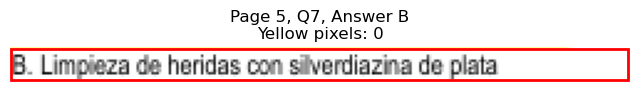

Page 5, Q7 - C: Detected box: x0=315.4, y0=480.8, x1=498.1, y1=493.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 910
Page 5, Q7, C: Yellow percentage: 0.0%


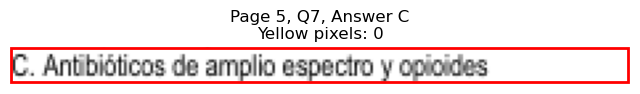

Page 5, Q7 - D: Detected box: x0=315.4, y0=493.4, x1=426.9, y1=506.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 554
Page 5, Q7, D: Yellow percentage: 0.0%


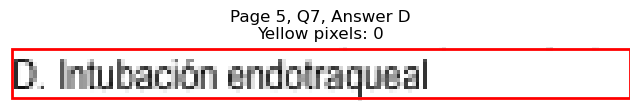


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=118.0, y1=543.8
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 274
Page 5, Q8, A: Yellow percentage: 0.0%


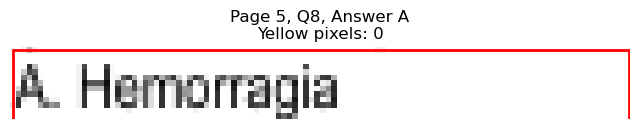

Page 5, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=97.9, y1=556.4
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 214
Page 5, Q8, B: Yellow percentage: 0.0%


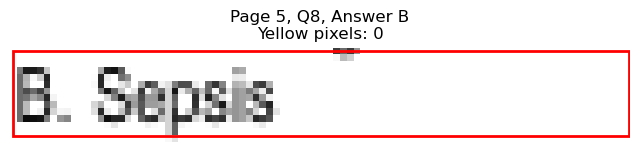

Page 5, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=369.7, y1=543.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 360
Page 5, Q8, C: Yellow percentage: 0.0%


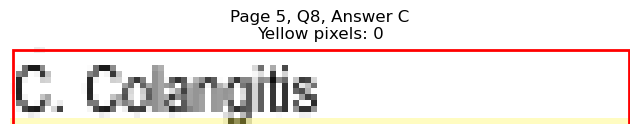

Page 5, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=390.8, y1=556.4
Page 5, Q8, D: Yellow pixels: 1347
Page 5, Q8, D: Total non-white pixels: 1764
Page 5, Q8, D: Yellow percentage: 76.4%


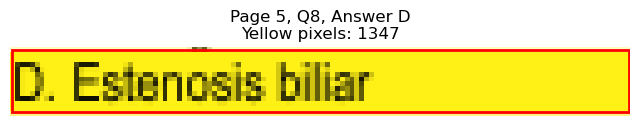


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=581.7, x1=352.1, y1=594.3
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 1418
Page 5, Q9, A: Yellow percentage: 0.0%


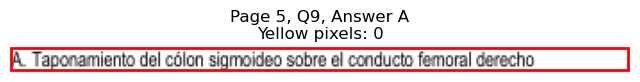

Page 5, Q9 - B: Detected box: x0=56.6, y0=594.3, x1=231.9, y1=606.9
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 830
Page 5, Q9, B: Yellow percentage: 0.0%


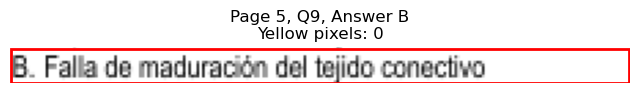

Page 5, Q9 - C: Detected box: x0=56.6, y0=606.9, x1=192.6, y1=619.5
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 664
Page 5, Q9, C: Yellow percentage: 0.0%


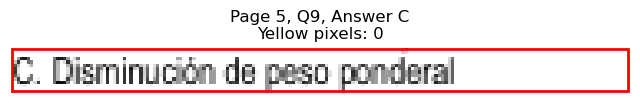

Page 5, Q9 - D: Detected box: x0=56.6, y0=619.6, x1=277.6, y1=632.3
Page 5, Q9, D: Yellow pixels: 2438
Page 5, Q9, D: Total non-white pixels: 3808
Page 5, Q9, D: Yellow percentage: 64.0%


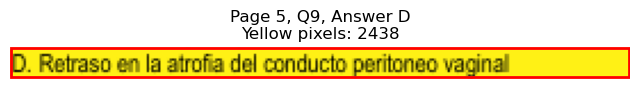


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)
Page 5, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=174.6, y1=682.7
Page 5, Q10, A: Yellow pixels: 1
Page 5, Q10, A: Total non-white pixels: 735
Page 5, Q10, A: Yellow percentage: 0.1%


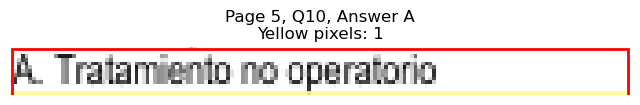

Page 5, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=171.1, y1=695.3
Page 5, Q10, B: Yellow pixels: 1553
Page 5, Q10, B: Total non-white pixels: 2324
Page 5, Q10, B: Yellow percentage: 66.8%


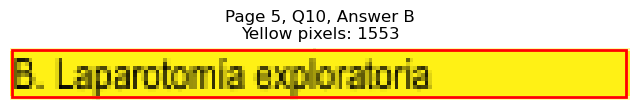

Page 5, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=353.1, y1=682.7
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 152
Page 5, Q10, C: Yellow percentage: 0.0%


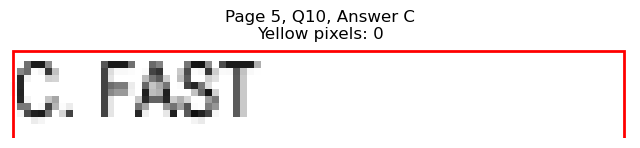

Page 5, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=420.3, y1=695.3
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 516
Page 5, Q10, D: Yellow percentage: 0.0%


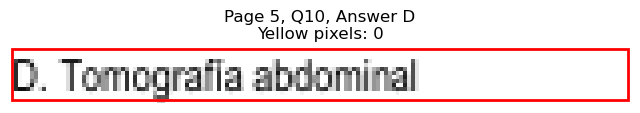


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)
Page 5, Q11 - A: Detected box: x0=56.6, y0=745.8, x1=177.6, y1=758.4
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 589
Page 5, Q11, A: Yellow percentage: 0.0%


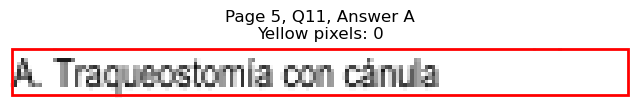

Page 5, Q11 - B: Detected box: x0=56.6, y0=758.5, x1=169.2, y1=771.1
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 589
Page 5, Q11, B: Yellow percentage: 0.0%


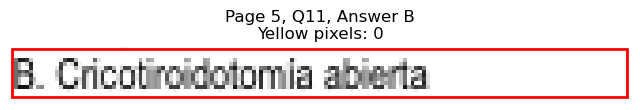

Page 5, Q11 - C: Detected box: x0=315.4, y0=745.8, x1=427.0, y1=758.4
Page 5, Q11, C: Yellow pixels: 1697
Page 5, Q11, C: Total non-white pixels: 2282
Page 5, Q11, C: Yellow percentage: 74.4%


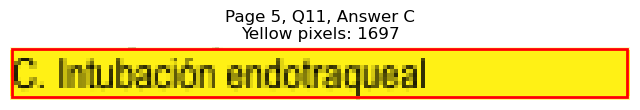

Page 5, Q11 - D: Detected box: x0=315.4, y0=758.5, x1=436.0, y1=771.1
Page 5, Q11, D: Yellow pixels: 171
Page 5, Q11, D: Total non-white pixels: 782
Page 5, Q11, D: Yellow percentage: 21.9%


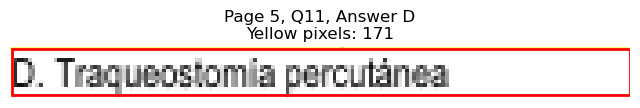


Page 5, Q11 - Selected Answer: C (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=89.4, x1=157.1, y1=102.1
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 537
Page 6, Q1, A: Yellow percentage: 0.0%


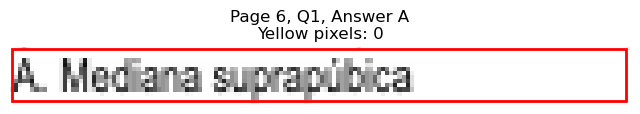

Page 6, Q1 - B: Detected box: x0=56.6, y0=102.0, x1=176.2, y1=114.7
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 624
Page 6, Q1, B: Yellow percentage: 0.0%


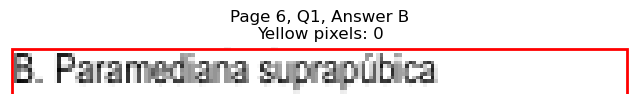

Page 6, Q1 - C: Detected box: x0=315.4, y0=89.4, x1=438.9, y1=102.1
Page 6, Q1, C: Yellow pixels: 174
Page 6, Q1, C: Total non-white pixels: 797
Page 6, Q1, C: Yellow percentage: 21.8%


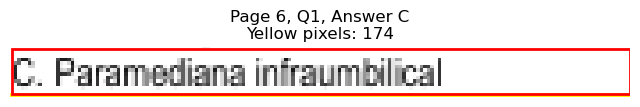

Page 6, Q1 - D: Detected box: x0=315.4, y0=102.0, x1=407.8, y1=114.7
Page 6, Q1, D: Yellow pixels: 1500
Page 6, Q1, D: Total non-white pixels: 1859
Page 6, Q1, D: Yellow percentage: 80.7%


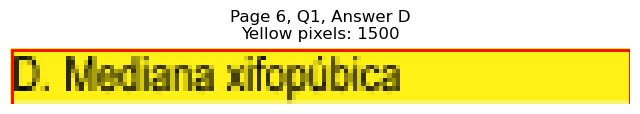


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=141.5, y1=177.8
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 571
Page 6, Q2, A: Yellow percentage: 0.0%


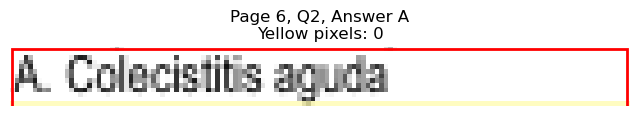

Page 6, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=133.5, y1=190.4
Page 6, Q2, B: Yellow pixels: 1218
Page 6, Q2, B: Total non-white pixels: 1792
Page 6, Q2, B: Yellow percentage: 68.0%


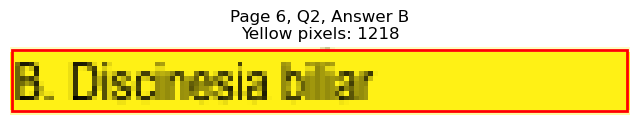

Page 6, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=408.8, y1=177.8
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 445
Page 6, Q2, C: Yellow percentage: 0.0%


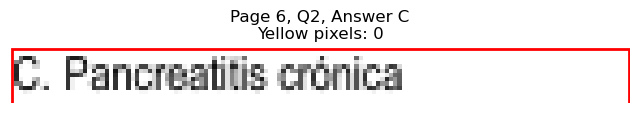

Page 6, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=397.3, y1=190.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 412
Page 6, Q2, D: Yellow percentage: 0.0%


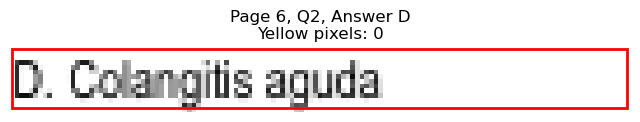


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=240.8, x1=234.3, y1=253.5
Page 6, Q3, A: Yellow pixels: 2273
Page 6, Q3, A: Total non-white pixels: 3164
Page 6, Q3, A: Yellow percentage: 71.8%


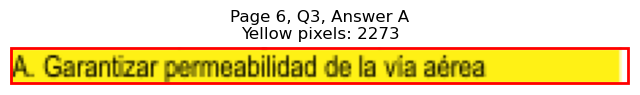

Page 6, Q3 - B: Detected box: x0=56.6, y0=253.4, x1=202.2, y1=266.1
Page 6, Q3, B: Yellow pixels: 197
Page 6, Q3, B: Total non-white pixels: 883
Page 6, Q3, B: Yellow percentage: 22.3%


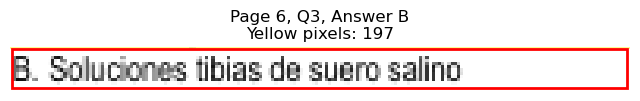

Page 6, Q3 - C: Detected box: x0=315.4, y0=240.8, x1=453.4, y1=253.5
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 664
Page 6, Q3, C: Yellow percentage: 0.0%


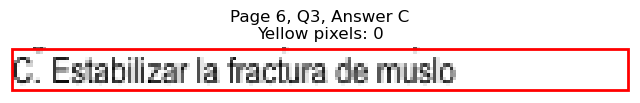

Page 6, Q3 - D: Detected box: x0=315.4, y0=253.4, x1=482.0, y1=266.1
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 781
Page 6, Q3, D: Yellow percentage: 0.0%


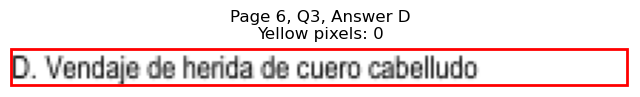


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=244.8, y1=304.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 905
Page 6, Q4, A: Yellow percentage: 0.0%


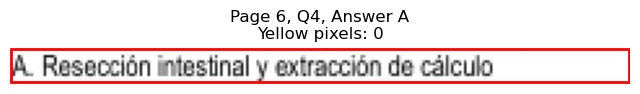

Page 6, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=217.8, y1=316.6
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 774
Page 6, Q4, B: Yellow percentage: 0.0%


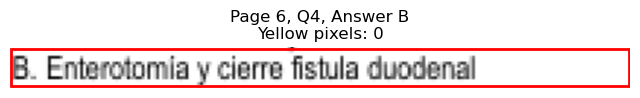

Page 6, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=480.1, y1=304.0
Page 6, Q4, C: Yellow pixels: 216
Page 6, Q4, C: Total non-white pixels: 1004
Page 6, Q4, C: Yellow percentage: 21.5%


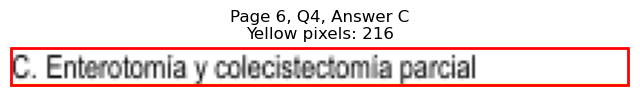

Page 6, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=473.1, y1=316.6
Page 6, Q4, D: Yellow pixels: 2137
Page 6, Q4, D: Total non-white pixels: 2722
Page 6, Q4, D: Yellow percentage: 78.5%


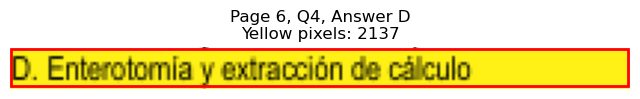


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=184.7, y1=379.8
Page 6, Q5, A: Yellow pixels: 1854
Page 6, Q5, A: Total non-white pixels: 2327
Page 6, Q5, A: Yellow percentage: 79.7%


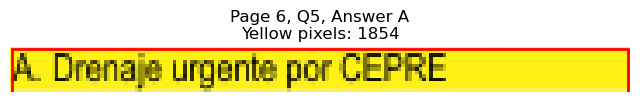

Page 6, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=121.6, y1=392.4
Page 6, Q5, B: Yellow pixels: 113
Page 6, Q5, B: Total non-white pixels: 433
Page 6, Q5, B: Yellow percentage: 26.1%


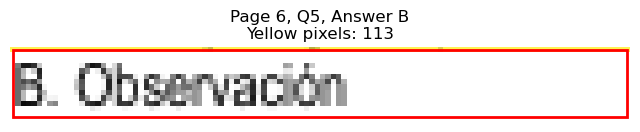

Page 6, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=466.0, y1=379.8
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 727
Page 6, Q5, C: Yellow percentage: 0.0%


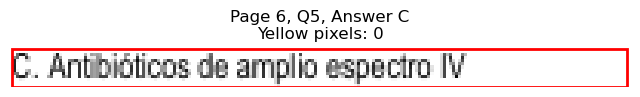

Page 6, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=392.2, y1=392.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 392
Page 6, Q5, D: Yellow percentage: 0.0%


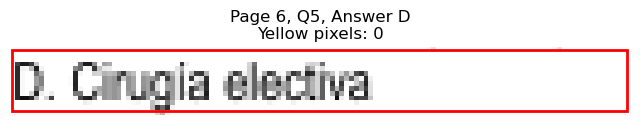


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=161.1, y1=468.1
Page 6, Q6, A: Yellow pixels: 1650
Page 6, Q6, A: Total non-white pixels: 2184
Page 6, Q6, A: Yellow percentage: 75.5%


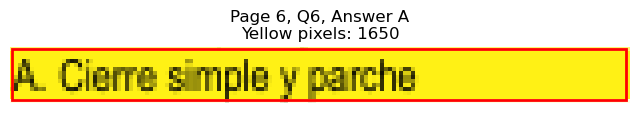

Page 6, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=202.2, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 938
Page 6, Q6, B: Yellow percentage: 0.0%


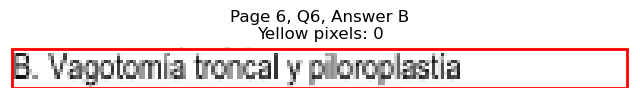

Page 6, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=431.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 580
Page 6, Q6, C: Yellow percentage: 0.0%


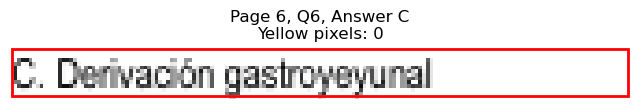

Page 6, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=433.9, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 608
Page 6, Q6, D: Yellow percentage: 0.0%


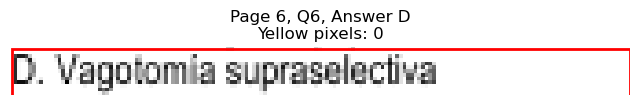


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=186.1, y1=531.2
Page 6, Q7, A: Yellow pixels: 1886
Page 6, Q7, A: Total non-white pixels: 2534
Page 6, Q7, A: Yellow percentage: 74.4%


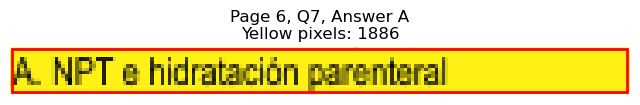

Page 6, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=300.0, y1=543.8
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 1511
Page 6, Q7, B: Yellow percentage: 0.0%


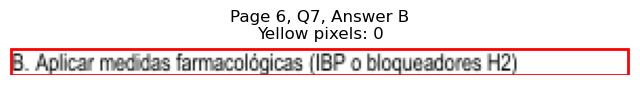

Page 6, Q7 - C: Detected box: x0=56.6, y0=543.8, x1=234.8, y1=556.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 878
Page 6, Q7, C: Yellow percentage: 0.0%


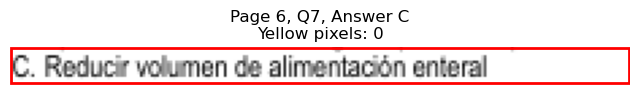

Page 6, Q7 - D: Detected box: x0=56.6, y0=556.5, x1=224.8, y1=569.1
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 835
Page 6, Q7, D: Yellow percentage: 0.0%


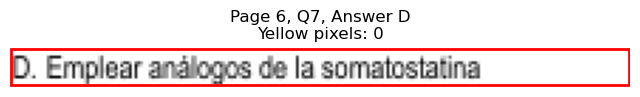


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=167.7, y1=606.9
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 546
Page 6, Q8, A: Yellow percentage: 0.0%


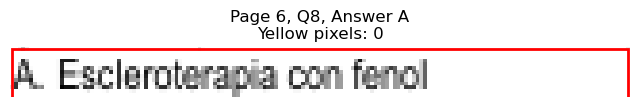

Page 6, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=186.6, y1=619.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 633
Page 6, Q8, B: Yellow percentage: 0.0%


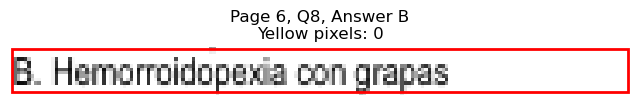

Page 6, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=455.0, y1=606.9
Page 6, Q8, C: Yellow pixels: 1967
Page 6, Q8, C: Total non-white pixels: 2470
Page 6, Q8, C: Yellow percentage: 79.6%


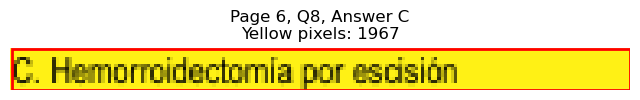

Page 6, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=441.4, y1=619.5
Page 6, Q8, D: Yellow pixels: 175
Page 6, Q8, D: Total non-white pixels: 835
Page 6, Q8, D: Yellow percentage: 21.0%


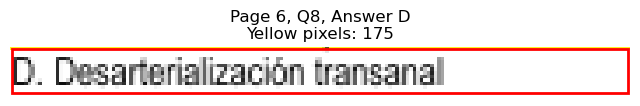


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=644.8, x1=178.1, y1=657.5
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 574
Page 6, Q9, A: Yellow percentage: 0.0%


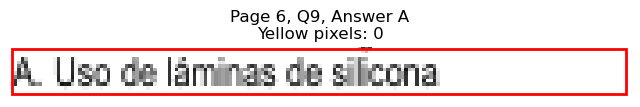

Page 6, Q9 - B: Detected box: x0=56.6, y0=657.4, x1=172.6, y1=670.1
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 565
Page 6, Q9, B: Yellow percentage: 0.0%


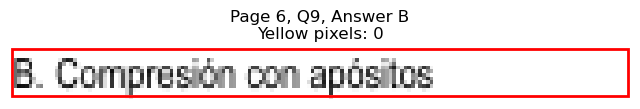

Page 6, Q9 - C: Detected box: x0=315.4, y0=644.8, x1=452.0, y1=657.5
Page 6, Q9, C: Yellow pixels: 1930
Page 6, Q9, C: Total non-white pixels: 2618
Page 6, Q9, C: Yellow percentage: 73.7%


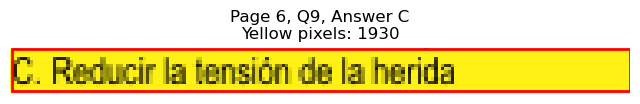

Page 6, Q9 - D: Detected box: x0=315.4, y0=657.4, x1=413.3, y1=670.1
Page 6, Q9, D: Yellow pixels: 149
Page 6, Q9, D: Total non-white pixels: 631
Page 6, Q9, D: Yellow percentage: 23.6%


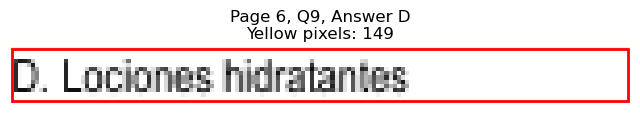


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=162.6, y1=733.2
Page 6, Q10, A: Yellow pixels: 157
Page 6, Q10, A: Total non-white pixels: 672
Page 6, Q10, A: Yellow percentage: 23.4%


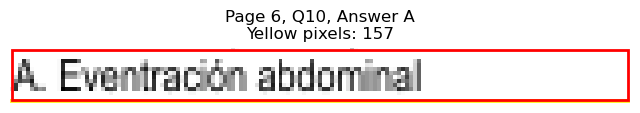

Page 6, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=142.6, y1=745.8
Page 6, Q10, B: Yellow pixels: 1438
Page 6, Q10, B: Total non-white pixels: 1781
Page 6, Q10, B: Yellow percentage: 80.7%


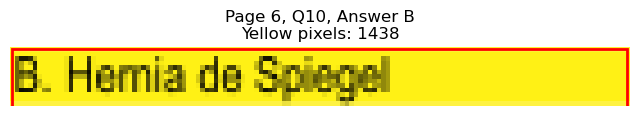

Page 6, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=419.8, y1=733.2
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 533
Page 6, Q10, C: Yellow percentage: 0.0%


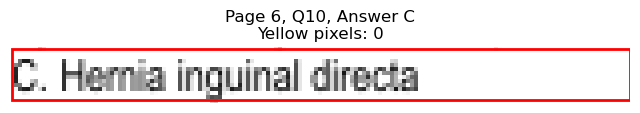

Page 6, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=406.3, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 459
Page 6, Q10, D: Yellow percentage: 0.0%


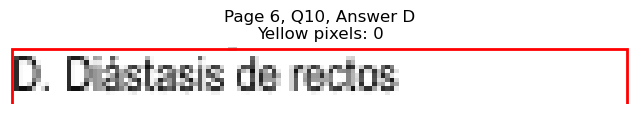


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)

Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=159.1, y1=127.3
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 492
Page 7, Q1, A: Yellow percentage: 0.0%


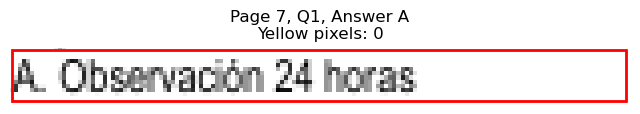

Page 7, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=193.7, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 671
Page 7, Q1, B: Yellow percentage: 0.0%


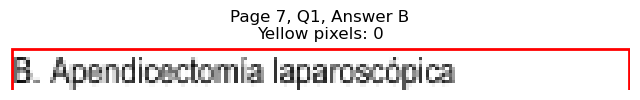

Page 7, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=432.9, y1=127.3
Page 7, Q1, C: Yellow pixels: 1604
Page 7, Q1, C: Total non-white pixels: 2352
Page 7, Q1, C: Yellow percentage: 68.2%


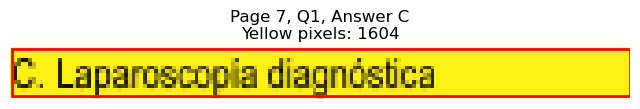

Page 7, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=430.9, y1=139.9
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 719
Page 7, Q1, D: Yellow percentage: 0.0%


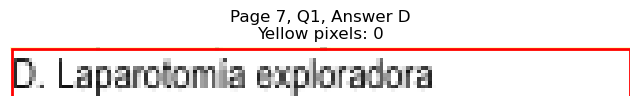


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=292.5, y1=177.8
Page 7, Q2, A: Yellow pixels: 2826
Page 7, Q2, A: Total non-white pixels: 3731
Page 7, Q2, A: Yellow percentage: 75.7%


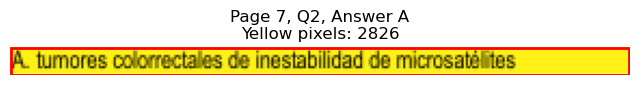

Page 7, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=260.3, y1=190.4
Page 7, Q2, B: Yellow pixels: 255
Page 7, Q2, B: Total non-white pixels: 1286
Page 7, Q2, B: Yellow percentage: 19.8%


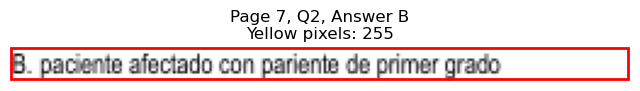

Page 7, Q2 - C: Detected box: x0=56.6, y0=190.3, x1=244.8, y1=203.0
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 944
Page 7, Q2, C: Yellow percentage: 0.0%


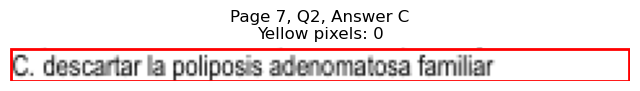

Page 7, Q2 - D: Detected box: x0=56.6, y0=202.9, x1=208.2, y1=215.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 774
Page 7, Q2, D: Yellow percentage: 0.0%


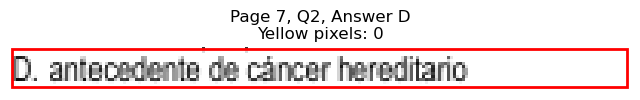


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=241.4, y1=266.1
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 908
Page 7, Q3, A: Yellow percentage: 0.0%


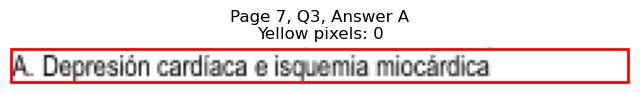

Page 7, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=195.7, y1=278.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 693
Page 7, Q3, B: Yellow percentage: 0.0%


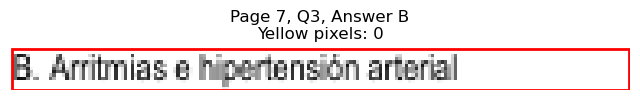

Page 7, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=515.6, y1=266.1
Page 7, Q3, C: Yellow pixels: 225
Page 7, Q3, C: Total non-white pixels: 1218
Page 7, Q3, C: Yellow percentage: 18.5%


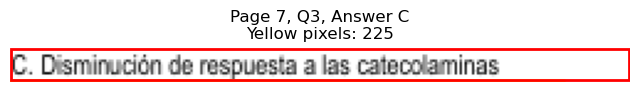

Page 7, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=537.3, y1=278.7
Page 7, Q3, D: Yellow pixels: 2149
Page 7, Q3, D: Total non-white pixels: 2938
Page 7, Q3, D: Yellow percentage: 73.1%


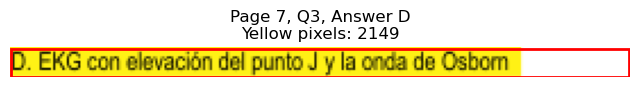


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=153.6, y1=341.8
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 479
Page 7, Q4, A: Yellow percentage: 0.0%


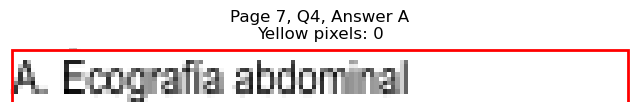

Page 7, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=95.9, y1=354.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 187
Page 7, Q4, B: Yellow percentage: 0.0%


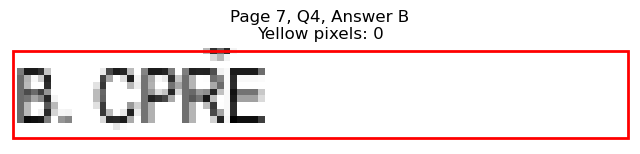

Page 7, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=412.3, y1=341.8
Page 7, Q4, C: Yellow pixels: 1555
Page 7, Q4, C: Total non-white pixels: 1924
Page 7, Q4, C: Yellow percentage: 80.8%


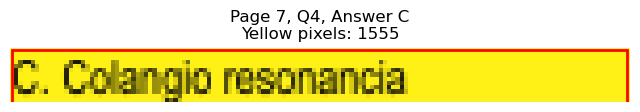

Page 7, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=420.3, y1=354.6
Page 7, Q4, D: Yellow pixels: 152
Page 7, Q4, D: Total non-white pixels: 675
Page 7, Q4, D: Yellow percentage: 22.5%


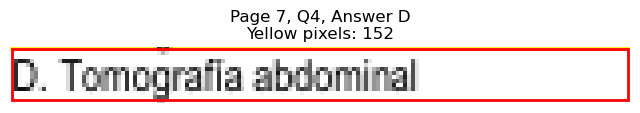


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=323.0, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 1306
Page 7, Q5, A: Yellow percentage: 0.0%


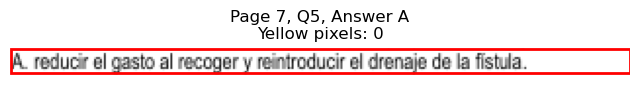

Page 7, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=195.7, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 638
Page 7, Q5, B: Yellow percentage: 0.0%


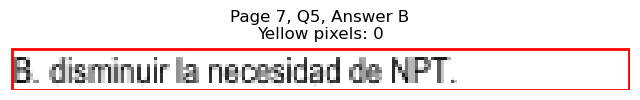

Page 7, Q5 - C: Detected box: x0=56.6, y0=404.9, x1=384.2, y1=417.6
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 1625
Page 7, Q5, C: Yellow percentage: 0.0%


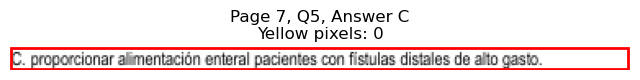

Page 7, Q5 - D: Detected box: x0=56.6, y0=417.6, x1=431.3, y1=430.3
Page 7, Q5, D: Yellow pixels: 3737
Page 7, Q5, D: Total non-white pixels: 5964
Page 7, Q5, D: Yellow percentage: 62.7%


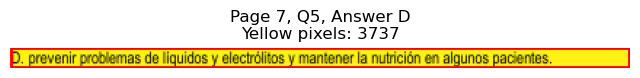


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=154.1, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 458
Page 7, Q6, A: Yellow percentage: 0.0%


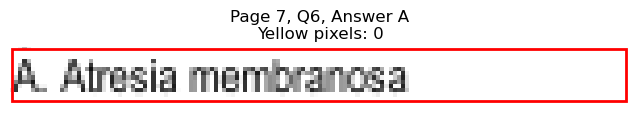

Page 7, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=127.9, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 342
Page 7, Q6, B: Yellow percentage: 0.0%


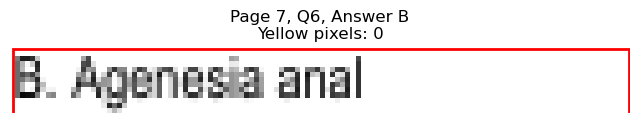

Page 7, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=388.7, y1=468.1
Page 7, Q6, C: Yellow pixels: 1348
Page 7, Q6, C: Total non-white pixels: 1736
Page 7, Q6, C: Yellow percentage: 77.6%


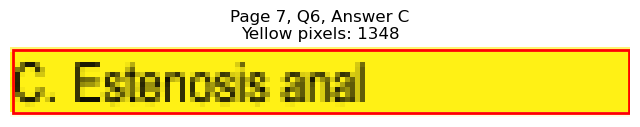

Page 7, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=410.3, y1=480.7
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 602
Page 7, Q6, D: Yellow percentage: 0.0%


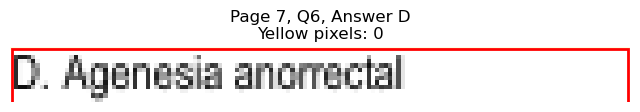


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=121.9, y1=531.2
Page 7, Q7, A: Yellow pixels: 116
Page 7, Q7, A: Total non-white pixels: 431
Page 7, Q7, A: Yellow percentage: 26.9%


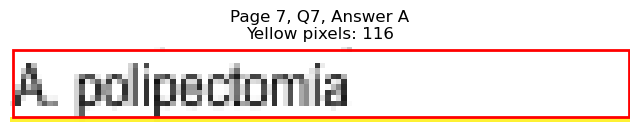

Page 7, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=166.6, y1=543.8
Page 7, Q7, B: Yellow pixels: 1640
Page 7, Q7, B: Total non-white pixels: 2093
Page 7, Q7, B: Yellow percentage: 78.4%


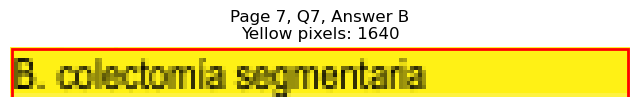

Page 7, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=383.2, y1=531.2
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 315
Page 7, Q7, C: Yellow percentage: 0.0%


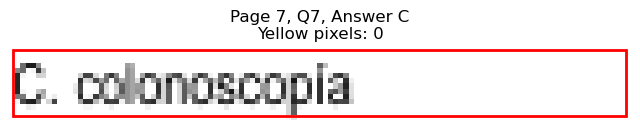

Page 7, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=393.3, y1=543.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 385
Page 7, Q7, D: Yellow percentage: 0.0%


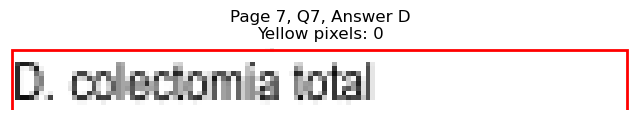


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=569.1, x1=168.6, y1=581.7
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 554
Page 7, Q8, A: Yellow percentage: 0.0%


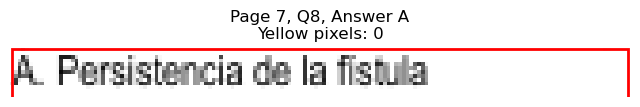

Page 7, Q8 - B: Detected box: x0=56.6, y0=581.7, x1=179.7, y1=594.3
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 561
Page 7, Q8, B: Yellow percentage: 0.0%


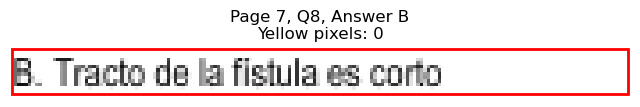

Page 7, Q8 - C: Detected box: x0=315.4, y0=569.1, x1=378.7, y1=581.7
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 421
Page 7, Q8, C: Yellow percentage: 0.0%


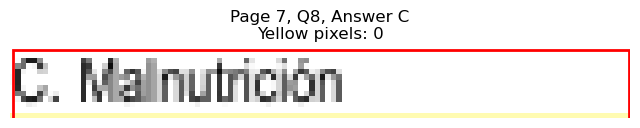

Page 7, Q8 - D: Detected box: x0=315.4, y0=581.7, x1=421.9, y1=594.3
Page 7, Q8, D: Yellow pixels: 1488
Page 7, Q8, D: Total non-white pixels: 2198
Page 7, Q8, D: Yellow percentage: 67.7%


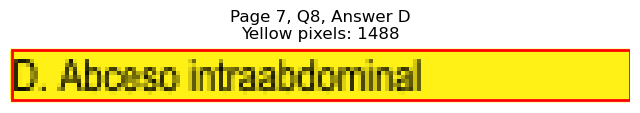


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=657.4, x1=173.1, y1=670.1
Page 7, Q9, A: Yellow pixels: 168
Page 7, Q9, A: Total non-white pixels: 732
Page 7, Q9, A: Yellow percentage: 23.0%


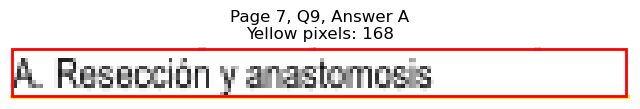

Page 7, Q9 - B: Detected box: x0=56.6, y0=670.0, x1=191.7, y1=682.7
Page 7, Q9, B: Yellow pixels: 1914
Page 7, Q9, B: Total non-white pixels: 2418
Page 7, Q9, B: Yellow percentage: 79.2%


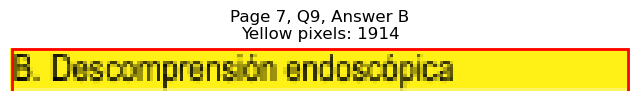

Page 7, Q9 - C: Detected box: x0=315.4, y0=657.4, x1=442.4, y1=670.1
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 621
Page 7, Q9, C: Yellow percentage: 0.0%


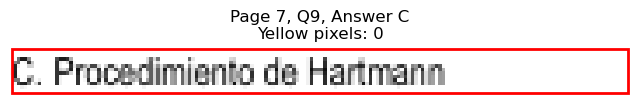

Page 7, Q9 - D: Detected box: x0=315.4, y0=670.0, x1=434.3, y1=682.7
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 588
Page 7, Q9, D: Yellow percentage: 0.0%


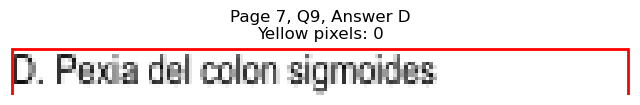


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)
Page 7, Q10 - A: Detected box: x0=56.6, y0=708.0, x1=148.0, y1=720.6
Page 7, Q10, A: Yellow pixels: 142
Page 7, Q10, A: Total non-white pixels: 599
Page 7, Q10, A: Yellow percentage: 23.7%


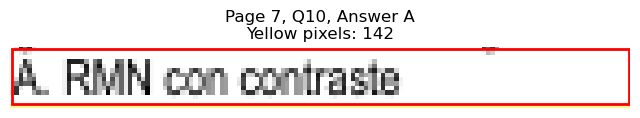

Page 7, Q10 - B: Detected box: x0=56.6, y0=720.6, x1=175.6, y1=733.2
Page 7, Q10, B: Yellow pixels: 1748
Page 7, Q10, B: Total non-white pixels: 2380
Page 7, Q10, B: Yellow percentage: 73.4%


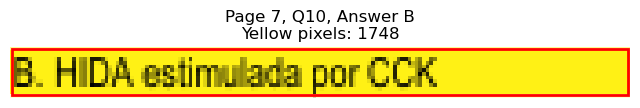

Page 7, Q10 - C: Detected box: x0=315.4, y0=708.0, x1=405.8, y1=720.6
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 418
Page 7, Q10, C: Yellow percentage: 0.0%


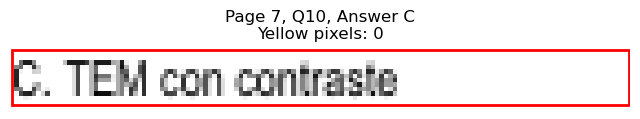

Page 7, Q10 - D: Detected box: x0=315.4, y0=720.6, x1=434.3, y1=733.2
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 561
Page 7, Q10, D: Yellow percentage: 0.0%


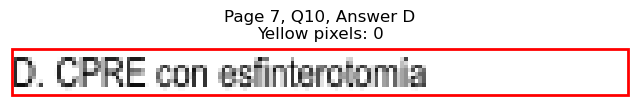


Page 7, Q10 - Selected Answer: B (based on yellow pixel count)

Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=198.3, y1=127.3
Page 8, Q1, A: Yellow pixels: 193
Page 8, Q1, A: Total non-white pixels: 893
Page 8, Q1, A: Yellow percentage: 21.6%


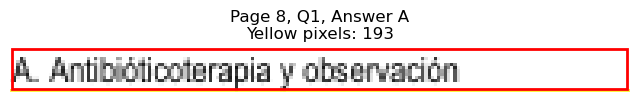

Page 8, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=227.3, y1=139.9
Page 8, Q1, B: Yellow pixels: 2208
Page 8, Q1, B: Total non-white pixels: 2886
Page 8, Q1, B: Yellow percentage: 76.5%


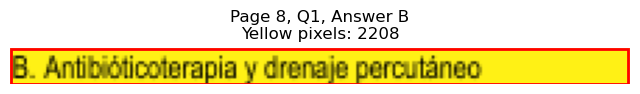

Page 8, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=472.1, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 778
Page 8, Q1, C: Yellow percentage: 0.0%


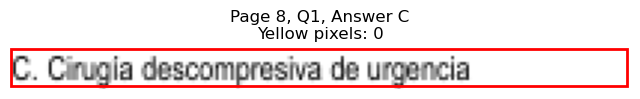

Page 8, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=425.3, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 519
Page 8, Q1, D: Yellow percentage: 0.0%


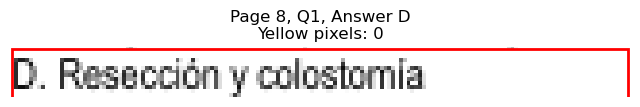


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=154.6, y1=190.4
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 450
Page 8, Q2, A: Yellow percentage: 0.0%


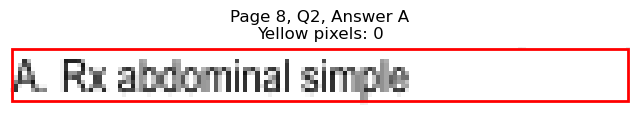

Page 8, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=136.5, y1=203.0
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 352
Page 8, Q2, B: Yellow percentage: 0.0%


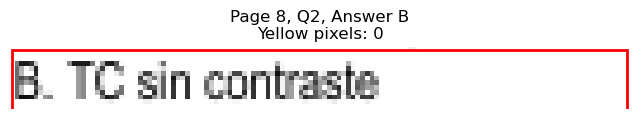

Page 8, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=530.1, y1=190.4
Page 8, Q2, C: Yellow pixels: 225
Page 8, Q2, C: Total non-white pixels: 1205
Page 8, Q2, C: Yellow percentage: 18.7%


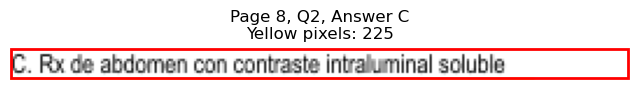

Page 8, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=414.9, y1=203.0
Page 8, Q2, D: Yellow pixels: 1630
Page 8, Q2, D: Total non-white pixels: 1950
Page 8, Q2, D: Yellow percentage: 83.6%


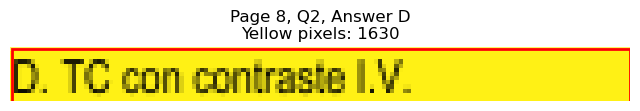


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=140.7, y1=240.9
Page 8, Q3, A: Yellow pixels: 1460
Page 8, Q3, A: Total non-white pixels: 1755
Page 8, Q3, A: Yellow percentage: 83.2%


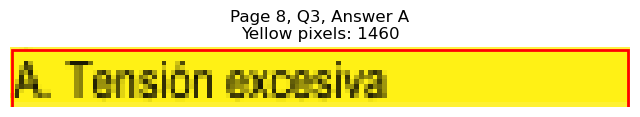

Page 8, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=148.6, y1=253.5
Page 8, Q3, B: Yellow pixels: 143
Page 8, Q3, B: Total non-white pixels: 551
Page 8, Q3, B: Yellow percentage: 26.0%


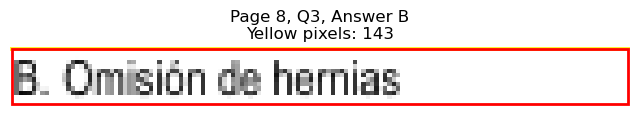

Page 8, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=491.7, y1=240.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 860
Page 8, Q3, C: Yellow percentage: 0.0%


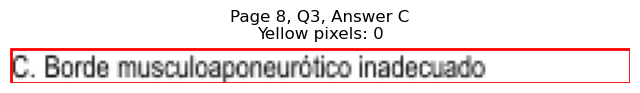

Page 8, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=458.5, y1=253.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 694
Page 8, Q3, D: Yellow percentage: 0.0%


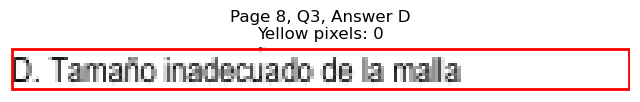


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=163.1, y1=304.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 485
Page 8, Q4, A: Yellow percentage: 0.0%


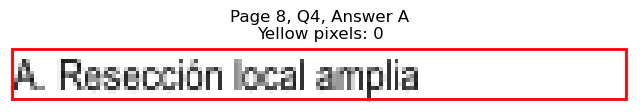

Page 8, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=145.6, y1=316.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 426
Page 8, Q4, B: Yellow percentage: 0.0%


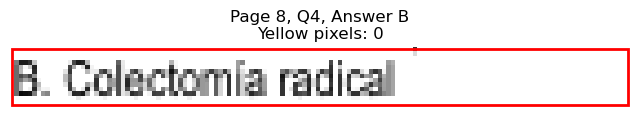

Page 8, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=427.4, y1=304.0
Page 8, Q4, C: Yellow pixels: 1697
Page 8, Q4, C: Total non-white pixels: 2282
Page 8, Q4, C: Yellow percentage: 74.4%


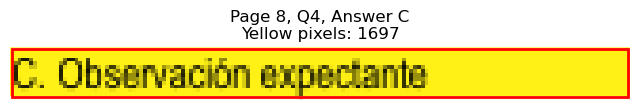

Page 8, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=375.8, y1=316.6
Page 8, Q4, D: Yellow pixels: 109
Page 8, Q4, D: Total non-white pixels: 513
Page 8, Q4, D: Yellow percentage: 21.2%


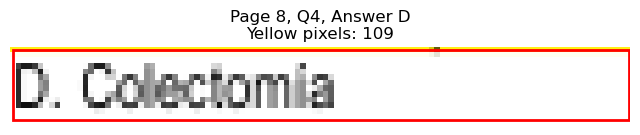


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=354.5, x1=216.8, y1=367.2
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 779
Page 8, Q5, A: Yellow percentage: 0.0%


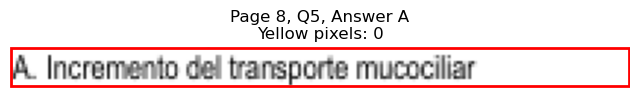

Page 8, Q5 - B: Detected box: x0=56.6, y0=367.1, x1=221.8, y1=379.8
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 830
Page 8, Q5, B: Yellow percentage: 0.0%


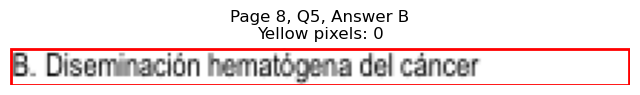

Page 8, Q5 - C: Detected box: x0=315.4, y0=354.5, x1=475.1, y1=367.2
Page 8, Q5, C: Yellow pixels: 2196
Page 8, Q5, C: Total non-white pixels: 2954
Page 8, Q5, C: Yellow percentage: 74.3%


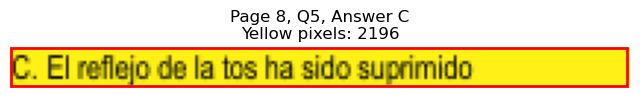

Page 8, Q5 - D: Detected box: x0=315.4, y0=367.1, x1=393.3, y1=379.8
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 517
Page 8, Q5, D: Yellow percentage: 0.0%


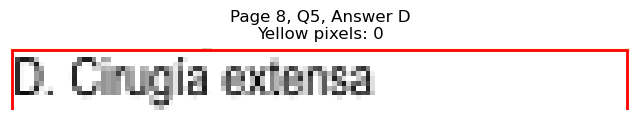


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=192.7, y1=430.3
Page 8, Q6, A: Yellow pixels: 1775
Page 8, Q6, A: Total non-white pixels: 2618
Page 8, Q6, A: Yellow percentage: 67.8%


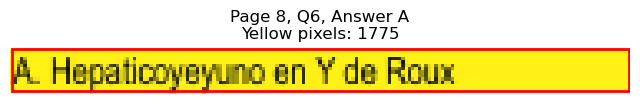

Page 8, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=160.1, y1=442.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 647
Page 8, Q6, B: Yellow percentage: 0.0%


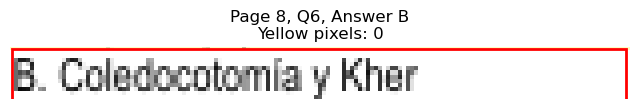

Page 8, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=382.7, y1=430.3
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 325
Page 8, Q6, C: Yellow percentage: 0.0%


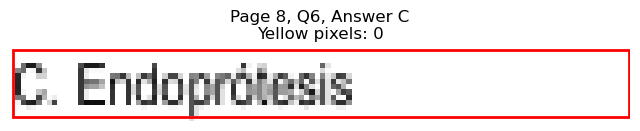

Page 8, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=448.9, y1=442.9
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 621
Page 8, Q6, D: Yellow percentage: 0.0%


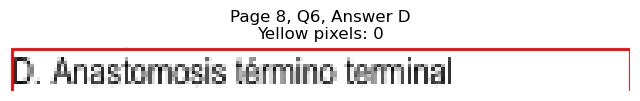


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=147.0, y1=480.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 413
Page 8, Q7, A: Yellow percentage: 0.0%


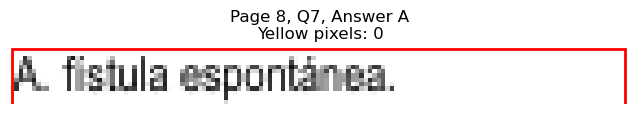

Page 8, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=146.1, y1=493.4
Page 8, Q7, B: Yellow pixels: 1352
Page 8, Q7, B: Total non-white pixels: 1974
Page 8, Q7, B: Yellow percentage: 68.5%


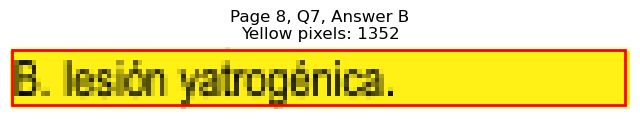

Page 8, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=429.9, y1=480.7
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 553
Page 8, Q7, C: Yellow percentage: 0.0%


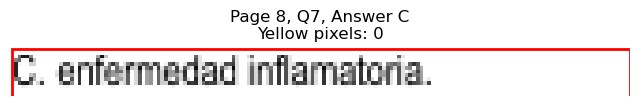

Page 8, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=399.8, y1=493.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 382
Page 8, Q7, D: Yellow percentage: 0.0%


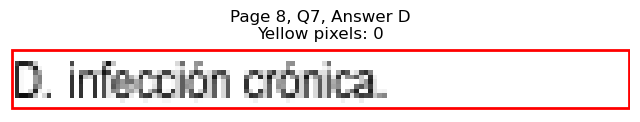


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=518.6, x1=102.9, y1=531.2
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 206
Page 8, Q8, A: Yellow percentage: 0.0%


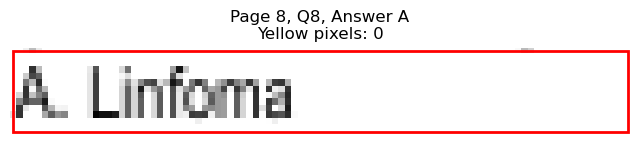

Page 8, Q8 - B: Detected box: x0=56.6, y0=531.2, x1=137.1, y1=543.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 381
Page 8, Q8, B: Yellow percentage: 0.0%


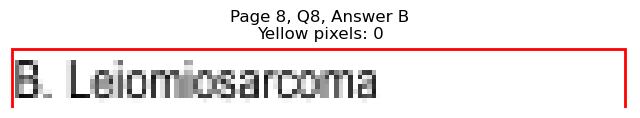

Page 8, Q8 - C: Detected box: x0=315.4, y0=518.6, x1=392.2, y1=531.2
Page 8, Q8, C: Yellow pixels: 128
Page 8, Q8, C: Total non-white pixels: 460
Page 8, Q8, C: Yellow percentage: 27.8%


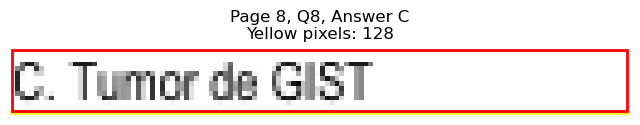

Page 8, Q8 - D: Detected box: x0=315.4, y0=531.2, x1=397.7, y1=543.8
Page 8, Q8, D: Yellow pixels: 1445
Page 8, Q8, D: Total non-white pixels: 1729
Page 8, Q8, D: Yellow percentage: 83.6%


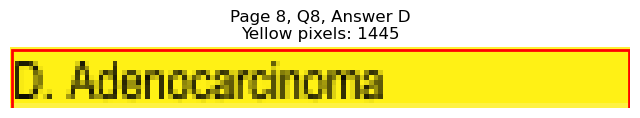


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=606.9, x1=153.0, y1=619.5
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 474
Page 8, Q9, A: Yellow percentage: 0.0%


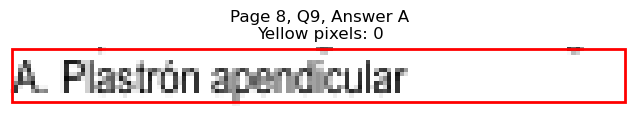

Page 8, Q9 - B: Detected box: x0=56.6, y0=619.6, x1=159.0, y1=632.3
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 489
Page 8, Q9, B: Yellow percentage: 0.0%


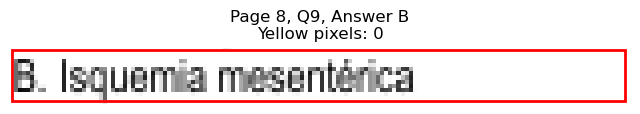

Page 8, Q9 - C: Detected box: x0=315.4, y0=606.9, x1=396.3, y1=619.5
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 373
Page 8, Q9, C: Yellow percentage: 0.0%


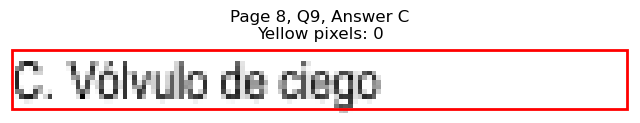

Page 8, Q9 - D: Detected box: x0=315.4, y0=619.6, x1=366.2, y1=632.3
Page 8, Q9, D: Yellow pixels: 1043
Page 8, Q9, D: Total non-white pixels: 1428
Page 8, Q9, D: Yellow percentage: 73.0%


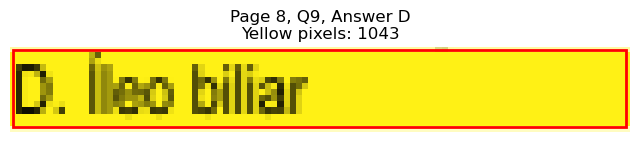


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)
Page 8, Q10 - A: Detected box: x0=56.6, y0=682.6, x1=187.7, y1=695.3
Page 8, Q10, A: Yellow pixels: 1706
Page 8, Q10, A: Total non-white pixels: 2548
Page 8, Q10, A: Yellow percentage: 67.0%


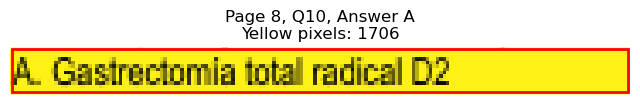

Page 8, Q10 - B: Detected box: x0=56.6, y0=695.4, x1=204.8, y1=708.0
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 931
Page 8, Q10, B: Yellow percentage: 0.0%


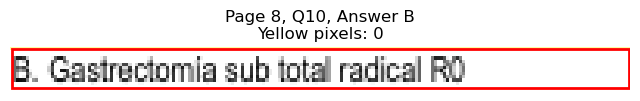

Page 8, Q10 - C: Detected box: x0=56.6, y0=708.0, x1=226.4, y1=720.6
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 807
Page 8, Q10, C: Yellow percentage: 0.0%


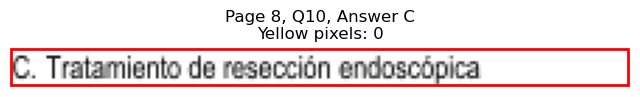

Page 8, Q10 - D: Detected box: x0=56.6, y0=720.6, x1=354.1, y1=733.2
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 1425
Page 8, Q10, D: Yellow percentage: 0.0%


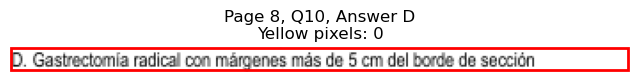


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)

Page 9: Found 11 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=218.2, y1=114.7
Page 9, Q1, A: Yellow pixels: 2177
Page 9, Q1, A: Total non-white pixels: 2769
Page 9, Q1, A: Yellow percentage: 78.6%


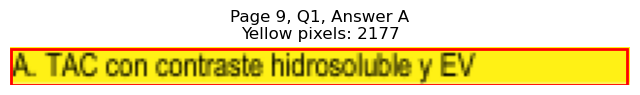

Page 9, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=142.5, y1=127.3
Page 9, Q1, B: Yellow pixels: 137
Page 9, Q1, B: Total non-white pixels: 528
Page 9, Q1, B: Yellow percentage: 25.9%


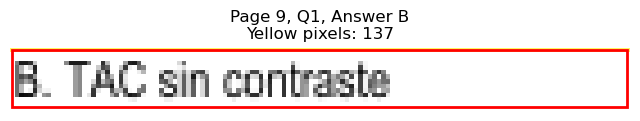

Page 9, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=413.3, y1=114.7
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 464
Page 9, Q1, C: Yellow percentage: 0.0%


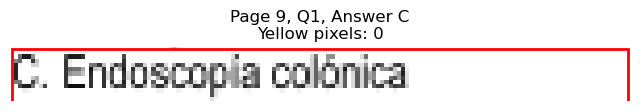

Page 9, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=449.5, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 643
Page 9, Q1, D: Yellow percentage: 0.0%


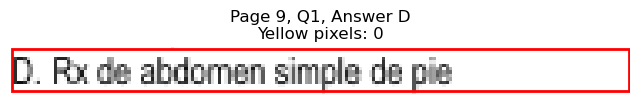


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=152.5, x1=121.5, y1=165.2
Page 9, Q2, A: Yellow pixels: 116
Page 9, Q2, A: Total non-white pixels: 429
Page 9, Q2, A: Yellow percentage: 27.0%


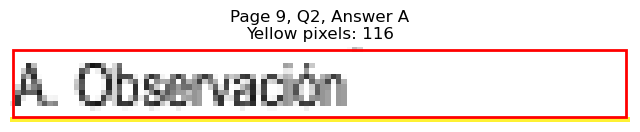

Page 9, Q2 - B: Detected box: x0=56.6, y0=165.1, x1=121.5, y1=177.8
Page 9, Q2, B: Yellow pixels: 1269
Page 9, Q2, B: Total non-white pixels: 1508
Page 9, Q2, B: Yellow percentage: 84.2%


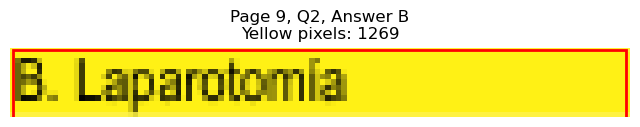

Page 9, Q2 - C: Detected box: x0=315.4, y0=152.5, x1=409.3, y1=165.2
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 462
Page 9, Q2, C: Yellow percentage: 0.0%


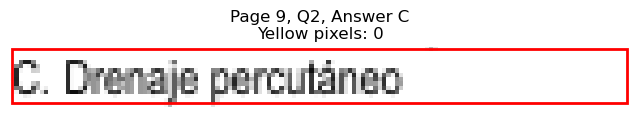

Page 9, Q2 - D: Detected box: x0=315.4, y0=165.1, x1=379.7, y1=177.8
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 334
Page 9, Q2, D: Yellow percentage: 0.0%


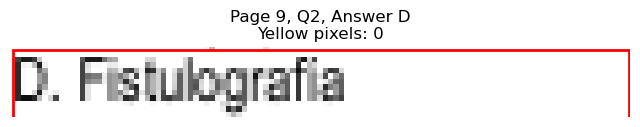


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=102.9, y1=240.9
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 218
Page 9, Q3, A: Yellow percentage: 0.0%


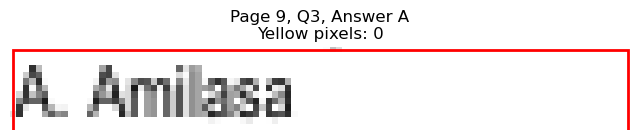

Page 9, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=134.5, y1=253.5
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 347
Page 9, Q3, B: Yellow percentage: 0.0%


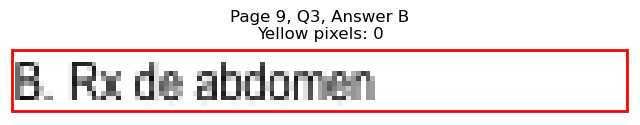

Page 9, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=412.9, y1=240.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 628
Page 9, Q3, C: Yellow percentage: 0.0%


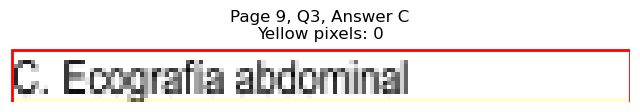

Page 9, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=356.7, y1=253.5
Page 9, Q3, D: Yellow pixels: 1068
Page 9, Q3, D: Total non-white pixels: 1288
Page 9, Q3, D: Yellow percentage: 82.9%


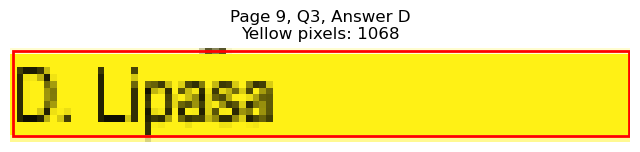


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=212.8, y1=316.6
Page 9, Q4, A: Yellow pixels: 1
Page 9, Q4, A: Total non-white pixels: 959
Page 9, Q4, A: Yellow percentage: 0.1%


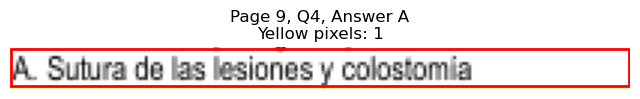

Page 9, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=274.0, y1=329.2
Page 9, Q4, B: Yellow pixels: 1913
Page 9, Q4, B: Total non-white pixels: 3204
Page 9, Q4, B: Yellow percentage: 59.7%


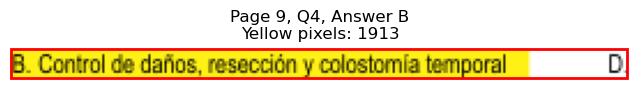

Page 9, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=467.6, y1=316.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 750
Page 9, Q4, C: Yellow percentage: 0.0%


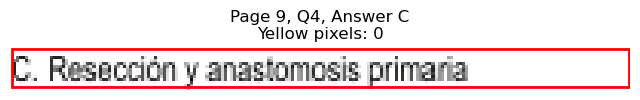

Page 9, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=423.4, y1=329.2
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 518
Page 9, Q4, D: Yellow percentage: 0.0%


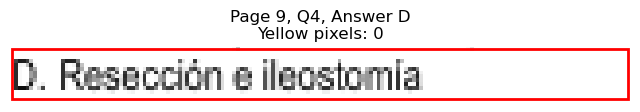


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=152.5, x1=121.5, y1=165.2
Page 9, Q5, A: Yellow pixels: 116
Page 9, Q5, A: Total non-white pixels: 429
Page 9, Q5, A: Yellow percentage: 27.0%


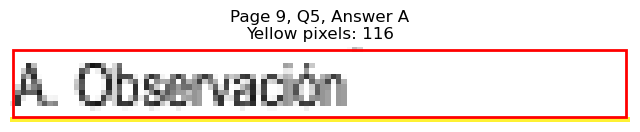

Page 9, Q5 - B: Detected box: x0=56.6, y0=165.1, x1=121.5, y1=177.8
Page 9, Q5, B: Yellow pixels: 1269
Page 9, Q5, B: Total non-white pixels: 1508
Page 9, Q5, B: Yellow percentage: 84.2%


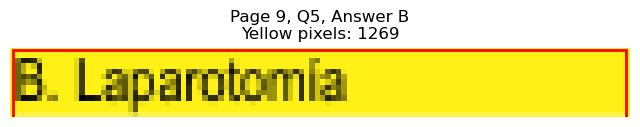

Page 9, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=353.1, y1=379.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 152
Page 9, Q5, C: Yellow percentage: 0.0%


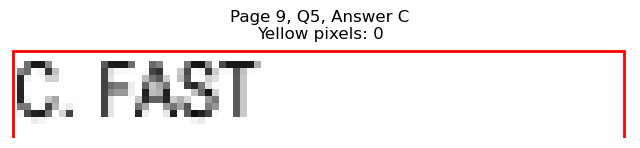

Page 9, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=347.6, y1=392.4
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 120
Page 9, Q5, D: Yellow percentage: 0.0%


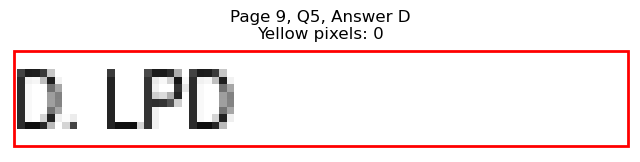


Page 9, Q5 - Selected Answer: B (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=417.6, x1=128.5, y1=430.3
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 318
Page 9, Q6, A: Yellow percentage: 0.0%


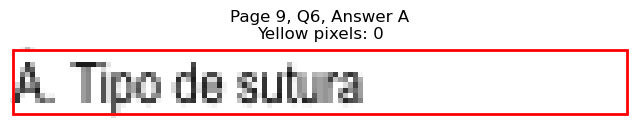

Page 9, Q6 - B: Detected box: x0=56.6, y0=430.2, x1=109.5, y1=442.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 275
Page 9, Q6, B: Yellow percentage: 0.0%


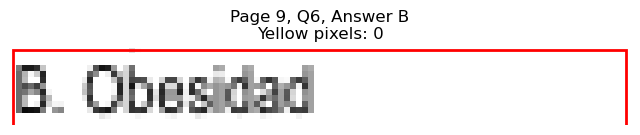

Page 9, Q6 - C: Detected box: x0=315.4, y0=417.6, x1=374.2, y1=430.3
Page 9, Q6, C: Yellow pixels: 110
Page 9, Q6, C: Total non-white pixels: 403
Page 9, Q6, C: Yellow percentage: 27.3%


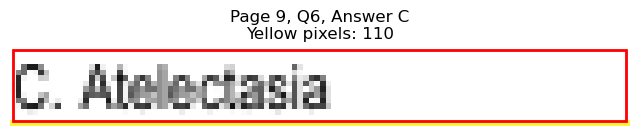

Page 9, Q6 - D: Detected box: x0=315.4, y0=430.2, x1=439.4, y1=442.9
Page 9, Q6, D: Yellow pixels: 1796
Page 9, Q6, D: Total non-white pixels: 2275
Page 9, Q6, D: Yellow percentage: 78.9%


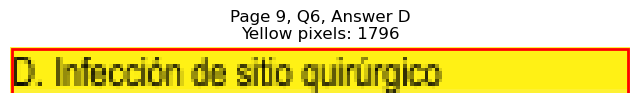


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=468.1, x1=160.1, y1=480.7
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 484
Page 9, Q7, A: Yellow percentage: 0.0%


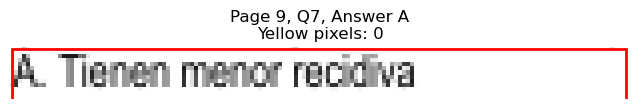

Page 9, Q7 - B: Detected box: x0=56.6, y0=480.8, x1=143.1, y1=493.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 384
Page 9, Q7, B: Yellow percentage: 0.0%


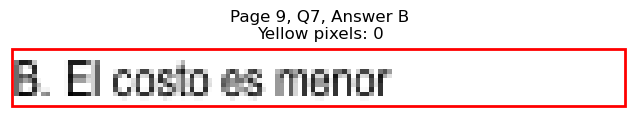

Page 9, Q7 - C: Detected box: x0=315.4, y0=468.1, x1=505.7, y1=480.7
Page 9, Q7, C: Yellow pixels: 2230
Page 9, Q7, C: Total non-white pixels: 2938
Page 9, Q7, C: Yellow percentage: 75.9%


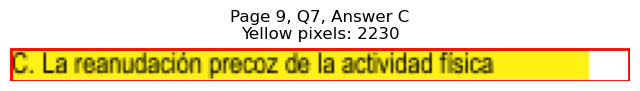

Page 9, Q7 - D: Detected box: x0=315.4, y0=480.8, x1=463.4, y1=493.4
Page 9, Q7, D: Yellow pixels: 199
Page 9, Q7, D: Total non-white pixels: 892
Page 9, Q7, D: Yellow percentage: 22.3%


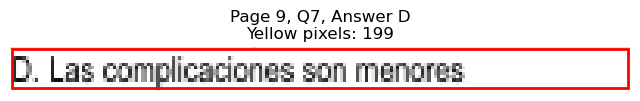


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=531.2, x1=141.5, y1=543.8
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 412
Page 9, Q8, A: Yellow percentage: 0.0%


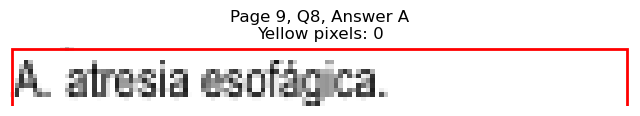

Page 9, Q8 - B: Detected box: x0=56.6, y0=543.8, x1=144.5, y1=556.4
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 453
Page 9, Q8, B: Yellow percentage: 0.0%


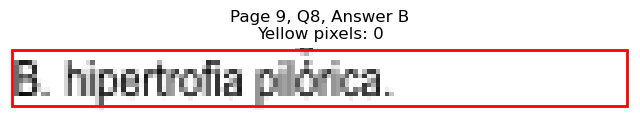

Page 9, Q8 - C: Detected box: x0=315.4, y0=531.2, x1=428.3, y1=543.8
Page 9, Q8, C: Yellow pixels: 1728
Page 9, Q8, C: Total non-white pixels: 2132
Page 9, Q8, C: Yellow percentage: 81.1%


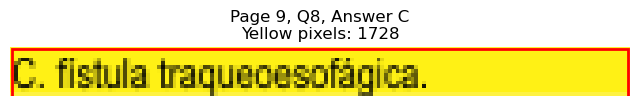

Page 9, Q8 - D: Detected box: x0=315.4, y0=543.8, x1=423.3, y1=556.4
Page 9, Q8, D: Yellow pixels: 154
Page 9, Q8, D: Total non-white pixels: 704
Page 9, Q8, D: Yellow percentage: 21.9%


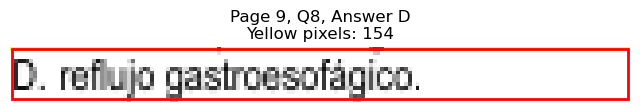


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=619.6, x1=172.1, y1=632.3
Page 9, Q9, A: Yellow pixels: 167
Page 9, Q9, A: Total non-white pixels: 738
Page 9, Q9, A: Yellow percentage: 22.6%


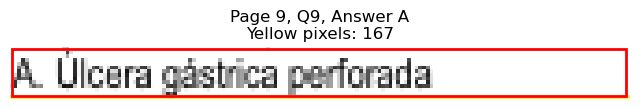

Page 9, Q9 - B: Detected box: x0=56.6, y0=632.2, x1=145.6, y1=644.9
Page 9, Q9, B: Yellow pixels: 1448
Page 9, Q9, B: Total non-white pixels: 1820
Page 9, Q9, B: Yellow percentage: 79.6%


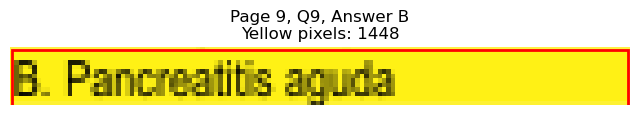

Page 9, Q9 - C: Detected box: x0=315.4, y0=619.6, x1=400.7, y1=632.3
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 435
Page 9, Q9, C: Yellow percentage: 0.0%


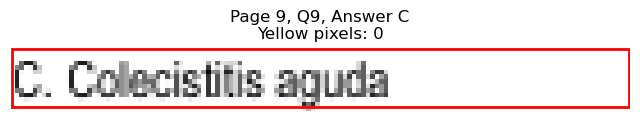

Page 9, Q9 - D: Detected box: x0=315.4, y0=632.2, x1=392.7, y1=644.9
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 406
Page 9, Q9, D: Yellow percentage: 0.0%


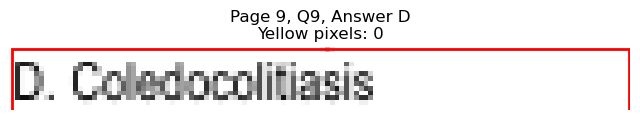


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)
Page 9, Q10 - A: Detected box: x0=56.6, y0=670.0, x1=141.5, y1=682.7
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 410
Page 9, Q10, A: Yellow percentage: 0.0%


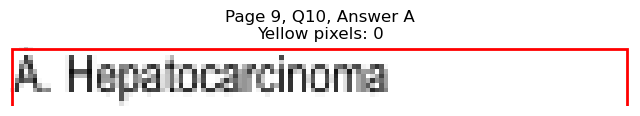

Page 9, Q10 - B: Detected box: x0=56.6, y0=682.6, x1=135.5, y1=695.3
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 359
Page 9, Q10, B: Yellow percentage: 0.0%


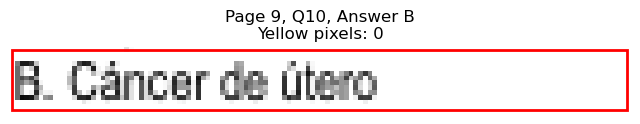

Page 9, Q10 - C: Detected box: x0=315.4, y0=670.0, x1=434.9, y1=682.7
Page 9, Q10, C: Yellow pixels: 1764
Page 9, Q10, C: Total non-white pixels: 2210
Page 9, Q10, C: Yellow percentage: 79.8%


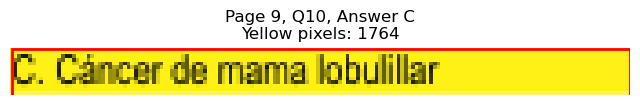

Page 9, Q10 - D: Detected box: x0=315.4, y0=682.6, x1=411.3, y1=695.3
Page 9, Q10, D: Yellow pixels: 147
Page 9, Q10, D: Total non-white pixels: 605
Page 9, Q10, D: Yellow percentage: 24.3%


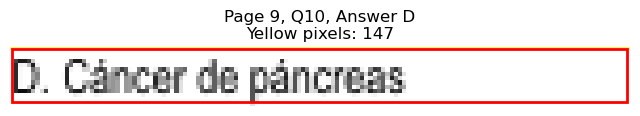


Page 9, Q10 - Selected Answer: C (based on yellow pixel count)
Page 9, Q11 - A: Detected box: x0=56.6, y0=733.2, x1=143.2, y1=745.8
Page 9, Q11, A: Yellow pixels: 0
Page 9, Q11, A: Total non-white pixels: 413
Page 9, Q11, A: Yellow percentage: 0.0%


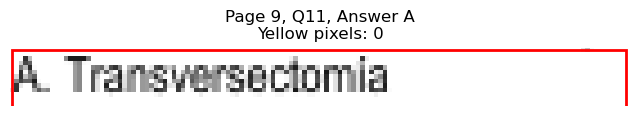

Page 9, Q11 - B: Detected box: x0=56.6, y0=745.8, x1=230.8, y1=758.4
Page 9, Q11, B: Yellow pixels: 0
Page 9, Q11, B: Total non-white pixels: 875
Page 9, Q11, B: Yellow percentage: 0.0%


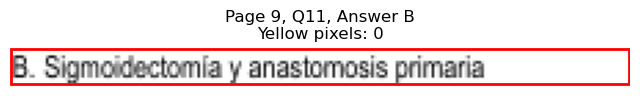

Page 9, Q11 - C: Detected box: x0=315.4, y0=733.2, x1=434.8, y1=745.8
Page 9, Q11, C: Yellow pixels: 1768
Page 9, Q11, C: Total non-white pixels: 2210
Page 9, Q11, C: Yellow percentage: 80.0%


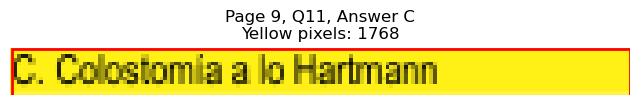

Page 9, Q11 - D: Detected box: x0=315.4, y0=745.8, x1=436.5, y1=758.4
Page 9, Q11, D: Yellow pixels: 172
Page 9, Q11, D: Total non-white pixels: 786
Page 9, Q11, D: Yellow percentage: 21.9%


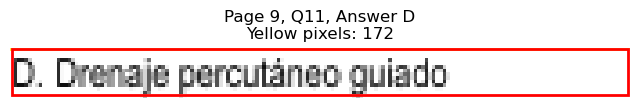


Page 9, Q11 - Selected Answer: C (based on yellow pixel count)

Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=164.7, y1=114.7
Page 10, Q1, A: Yellow pixels: 1654
Page 10, Q1, A: Total non-white pixels: 2067
Page 10, Q1, A: Yellow percentage: 80.0%


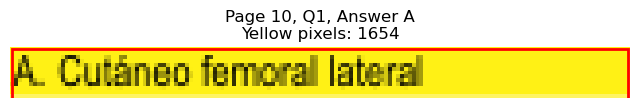

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=118.9, y1=127.3
Page 10, Q1, B: Yellow pixels: 113
Page 10, Q1, B: Total non-white pixels: 368
Page 10, Q1, B: Yellow percentage: 30.7%


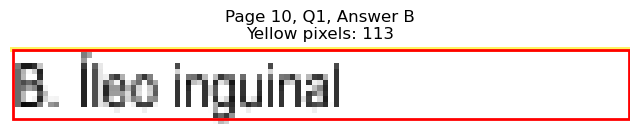

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=369.7, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 244
Page 10, Q1, C: Yellow percentage: 0.0%


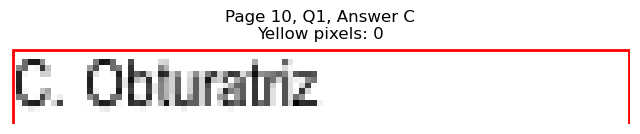

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=441.4, y1=127.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 620
Page 10, Q1, D: Yellow percentage: 0.0%


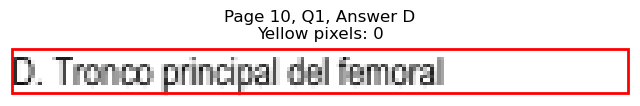


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=167.7, y1=177.8
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 545
Page 10, Q2, A: Yellow percentage: 0.0%


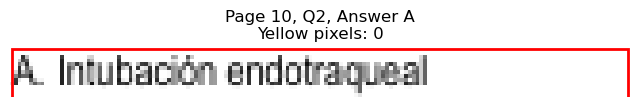

Page 10, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=226.4, y1=190.4
Page 10, Q2, B: Yellow pixels: 221
Page 10, Q2, B: Total non-white pixels: 1042
Page 10, Q2, B: Yellow percentage: 21.2%


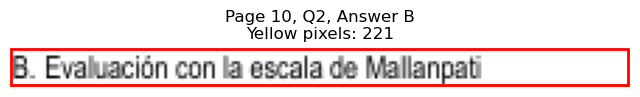

Page 10, Q2 - C: Detected box: x0=56.6, y0=190.3, x1=306.5, y1=203.0
Page 10, Q2, C: Yellow pixels: 2992
Page 10, Q2, C: Total non-white pixels: 3913
Page 10, Q2, C: Yellow percentage: 76.5%


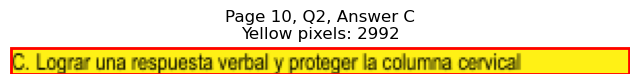

Page 10, Q2 - D: Detected box: x0=56.6, y0=202.9, x1=160.6, y1=215.6
Page 10, Q2, D: Yellow pixels: 146
Page 10, Q2, D: Total non-white pixels: 640
Page 10, Q2, D: Yellow percentage: 22.8%


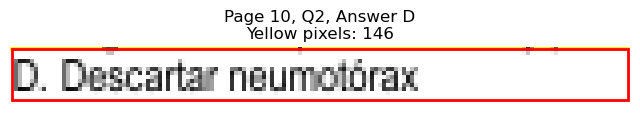


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=255.9, y1=266.1
Page 10, Q3, A: Yellow pixels: 225
Page 10, Q3, A: Total non-white pixels: 1221
Page 10, Q3, A: Yellow percentage: 18.4%


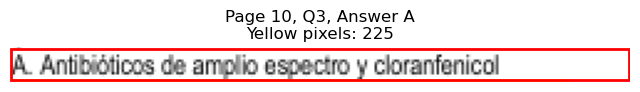

Page 10, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=254.9, y1=278.7
Page 10, Q3, B: Yellow pixels: 2127
Page 10, Q3, B: Total non-white pixels: 2938
Page 10, Q3, B: Yellow percentage: 72.4%


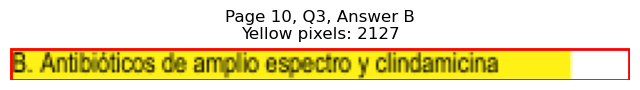

Page 10, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=444.4, y1=266.1
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 623
Page 10, Q3, C: Yellow percentage: 0.0%


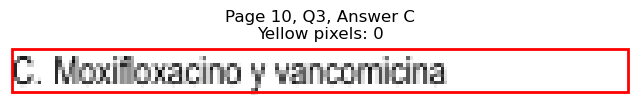

Page 10, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=441.4, y1=278.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 636
Page 10, Q3, D: Yellow percentage: 0.0%


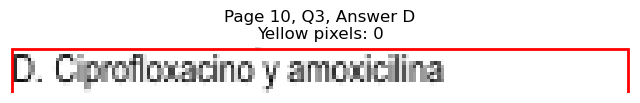


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=304.0, x1=148.6, y1=316.6
Page 10, Q4, A: Yellow pixels: 1500
Page 10, Q4, A: Total non-white pixels: 1868
Page 10, Q4, A: Yellow percentage: 80.3%


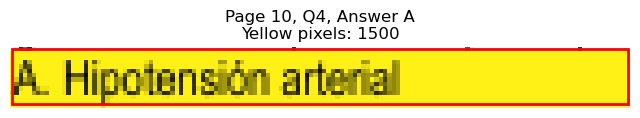

Page 10, Q4 - B: Detected box: x0=56.6, y0=316.6, x1=148.6, y1=329.2
Page 10, Q4, B: Yellow pixels: 143
Page 10, Q4, B: Total non-white pixels: 563
Page 10, Q4, B: Yellow percentage: 25.4%


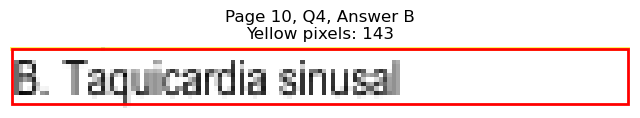

Page 10, Q4 - C: Detected box: x0=315.4, y0=304.0, x1=399.4, y1=316.6
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 405
Page 10, Q4, C: Yellow percentage: 0.0%


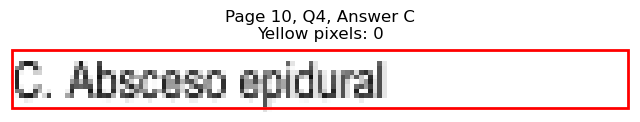

Page 10, Q4 - D: Detected box: x0=315.4, y0=316.6, x1=410.8, y1=329.2
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 489
Page 10, Q4, D: Yellow percentage: 0.0%


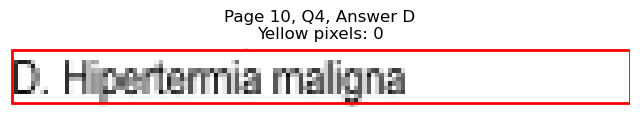


Page 10, Q4 - Selected Answer: A (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=367.1, x1=120.0, y1=379.8
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 412
Page 10, Q5, A: Yellow percentage: 0.0%


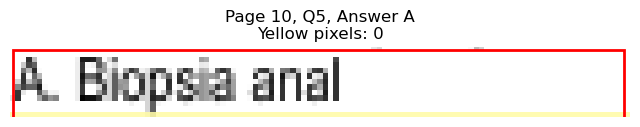

Page 10, Q5 - B: Detected box: x0=56.6, y0=379.7, x1=101.4, y1=392.4
Page 10, Q5, B: Yellow pixels: 990
Page 10, Q5, B: Total non-white pixels: 1344
Page 10, Q5, B: Yellow percentage: 73.7%


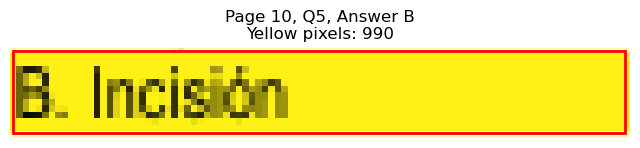

Page 10, Q5 - C: Detected box: x0=315.4, y0=367.1, x1=382.7, y1=379.8
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 318
Page 10, Q5, C: Yellow percentage: 0.0%


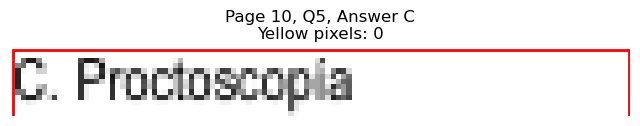

Page 10, Q5 - D: Detected box: x0=315.4, y0=379.7, x1=413.3, y1=392.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 488
Page 10, Q5, D: Yellow percentage: 0.0%


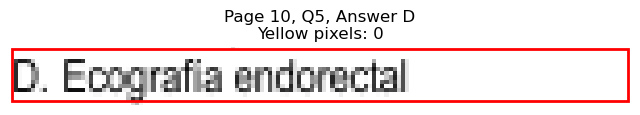


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=442.8, x1=97.9, y1=455.5
Page 10, Q6, A: Yellow pixels: 92
Page 10, Q6, A: Total non-white pixels: 300
Page 10, Q6, A: Yellow percentage: 30.7%


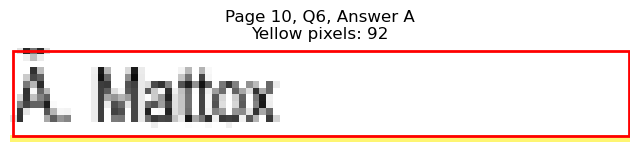

Page 10, Q6 - B: Detected box: x0=56.6, y0=455.5, x1=98.9, y1=468.1
Page 10, Q6, B: Yellow pixels: 1051
Page 10, Q6, B: Total non-white pixels: 1302
Page 10, Q6, B: Yellow percentage: 80.7%


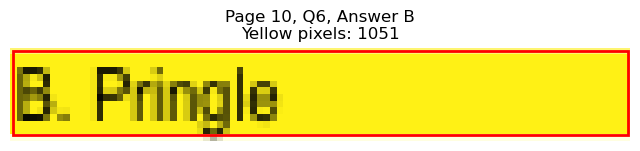

Page 10, Q6 - C: Detected box: x0=315.4, y0=442.8, x1=358.6, y1=455.5
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 210
Page 10, Q6, C: Yellow percentage: 0.0%


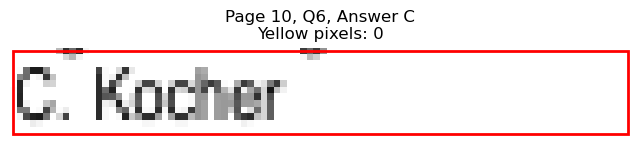

Page 10, Q6 - D: Detected box: x0=315.4, y0=455.5, x1=355.1, y1=468.1
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 169
Page 10, Q6, D: Yellow percentage: 0.0%


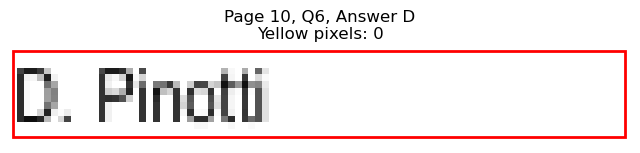


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=493.4, x1=250.4, y1=506.0
Page 10, Q7, A: Yellow pixels: 2188
Page 10, Q7, A: Total non-white pixels: 2945
Page 10, Q7, A: Yellow percentage: 74.3%


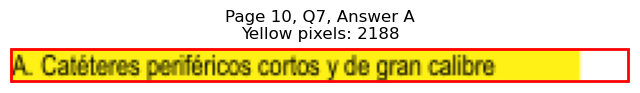

Page 10, Q7 - B: Detected box: x0=56.6, y0=506.0, x1=217.4, y1=518.6
Page 10, Q7, B: Yellow pixels: 204
Page 10, Q7, B: Total non-white pixels: 969
Page 10, Q7, B: Yellow percentage: 21.1%


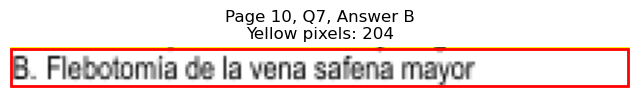

Page 10, Q7 - C: Detected box: x0=315.4, y0=493.4, x1=440.5, y1=506.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 587
Page 10, Q7, C: Yellow percentage: 0.0%


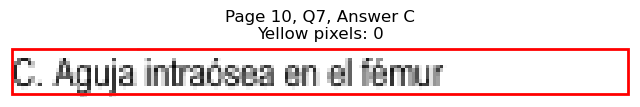

Page 10, Q7 - D: Detected box: x0=315.4, y0=506.0, x1=466.4, y1=518.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 754
Page 10, Q7, D: Yellow percentage: 0.0%


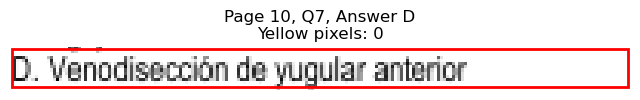


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 70 años operado por trombosis mesenté...
1   ¿Cuál es la complicación más común en la hemor...
2   Mujer de 60 años, sometida a gastrectomía subt...
3   ¿Cuál es la indicación quirúrgica de urgencia ...
4   Mujer de 32 años, durante una apendicectomía s...
..                                                ...
95  Varón de 60 años, obeso, presenta síndrome de ...
96  ¿Cuál es la complicación que se puede presenta...
97  Varón de 40 años, desde hace tres días present...
98  Varón de 60 años que sufre accidente de tránsi...
99  ¿Cuál acceso intravenoso se recomienda ante el...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                              Evitar la dermatitis   
1                         Hemorragia postoperatoria   
2                                    Dumping tardío   
3                                  Megacolon tóxico   
4                            Hemicolectomía derecha   
..                                              ...   
95  Antibióticos de amplio espectro y cloranfenicol   
96                             Hipotensión arterial   
97                                     Biopsia anal   
98                                           Mattox   
99   Catéteres periféricos cortos y de gran calibre   

                                          option_B  \
0                             Controlar la diarrea   
1                               Retención urinaria   
2                               Vaciamiento rápido   
3                           Fístula enteroentérica   
4    Apendicectomía con resección del mesoapéndice   
..                                             ...   
95  Antibióticos de amplio espectro y clindamicina   
96                             Taquicardia sinusal   
97                                        Incisión   
98                                         Pringle   
99              Flebotomía de la vena safena mayor   

                          option_C  \
0   Evitar déficit de Vitamina B12   
1                   Estenosis anal   
2        Intolerancia a la lactosa   
3                  Fisura perineal   
4            Apendicectomía simple   
..                             ...   
95     Moxifloxacino y vancomicina   
96                Absceso epidural   
97                    Proctoscopía   
98                          Kocher   
99     Aguja intraósea en el fémur   

                                             option_D  
0                         Control de hipergastrinemia  
1                                 Incontinencia fecal  
2            Intolerancia a suplementos nutricionales  
3                                   Neoplasia maligna  
4   Hemicolectomía derecha y linfoadenectomía regi...  
..                                                ...  
95                       Ciprofloxacino y amoxicilina  
96                                Hipertermia maligna  
97                               Ecografía endorectal  
98                                            Pinotti  
99                  Venodisección de yugular anterior  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               B
1               B
2               A
3               A
4               D
..            ...
95              B
96              A
97              B
98              B
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Varón de 70 años operado por trombosis mesenté...   
1   ¿Cuál es la complicación más común en la hemor...   
2   Mujer de 60 años, sometida a gastrectomía subt...   
3   ¿Cuál es la indicación quirúrgica de urgencia ...   
4   Mujer de 32 años, durante una apendicectomía s...   
..                                                ...   
95  Varón de 60 años, obeso, presenta síndrome de ...   
96  ¿Cuál es la complicación que se puede presenta...   
97  Varón de 40 años, desde hace tres días present...   
98  Varón de 60 años que sufre accidente de tránsi...   
99  ¿Cuál acceso intravenoso se recomienda ante el...   

                                           option_A  \
0                              Evitar la dermatitis   
1                         Hemorragia postoperatoria   
2                                    Dumping tardío   
3                                  Megacolon tóxico   
4                            Hemicolectomía derecha   
..                                              ...   
95  Antibióticos de amplio espectro y cloranfenicol   
96                             Hipotensión arterial   
97                                     Biopsia anal   
98                                           Mattox   
99   Catéteres periféricos cortos y de gran calibre   

                                          option_B  \
0                             Controlar la diarrea   
1                               Retención urinaria   
2                               Vaciamiento rápido   
3                           Fístula enteroentérica   
4    Apendicectomía con resección del mesoapéndice   
..                                             ...   
95  Antibióticos de amplio espectro y clindamicina   
96                             Taquicardia sinusal   
97                                        Incisión   
98                                         Pringle   
99              Flebotomía de la vena safena mayor   

                          option_C  \
0   Evitar déficit de Vitamina B12   
1                   Estenosis anal   
2        Intolerancia a la lactosa   
3                  Fisura perineal   
4            Apendicectomía simple   
..                             ...   
95     Moxifloxacino y vancomicina   
96                Absceso epidural   
97                    Proctoscopía   
98                          Kocher   
99     Aguja intraósea en el fémur   

                                             option_D correct_answer  
0                         Control de hipergastrinemia              B  
1                                 Incontinencia fecal              B  
2            Intolerancia a suplementos nutricionales              A  
3                                   Neoplasia maligna              A  
4   Hemicolectomía derecha y linfoadenectomía regi...              D  
..                                                ...            ...  
95                       Ciprofloxacino y amoxicilina              B  
96                                Hipertermia maligna              A  
97                               Ecografía endorectal              B  
98                                            Pinotti              B  
99                  Venodisección de yugular anterior              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/CIRUGÍA.csv
